### Optout model

### 01. Packages and connection

In [1]:
import pandas as pd
from pyathena import connect
import matplotlib.pyplot as plt
import joblib
import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from functools import reduce

# create a connection to Athena
conn = connect(s3_staging_dir = 's3://aws-athena-query-results-341377015103-eu-west-2/',
                   region_name='eu-west-2') 

In [2]:
pd.options.display.max_columns = 500

### 02. Getting 1s and 0s

#### EE SMS and MMS only at the moment

In [10]:
start = pd.to_datetime('2020-01-01', format='%Y-%m-%d')
end = pd.to_datetime('2020-08-31', format='%Y-%m-%d')
datepoints = []
for i in range((end-start).days):    
    datepoints.append((start+pd.DateOffset(days=i)).strftime('%Y-%m-%d'))

datepoints

['2020-01-01',
 '2020-01-02',
 '2020-01-03',
 '2020-01-04',
 '2020-01-05',
 '2020-01-06',
 '2020-01-07',
 '2020-01-08',
 '2020-01-09',
 '2020-01-10',
 '2020-01-11',
 '2020-01-12',
 '2020-01-13',
 '2020-01-14',
 '2020-01-15',
 '2020-01-16',
 '2020-01-17',
 '2020-01-18',
 '2020-01-19',
 '2020-01-20',
 '2020-01-21',
 '2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-25',
 '2020-01-26',
 '2020-01-27',
 '2020-01-28',
 '2020-01-29',
 '2020-01-30',
 '2020-01-31',
 '2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-

In [ ]:
# Getting optouts for a few days
# Both 1s 0s
# Start from 2020-01-01 to 2020-08-31
    
for i in datepoints:    
    pd.read_sql("Drop table if exists campaign_data.sd_opt_0a_" + i.replace('-', ''), conn)
    pd.read_sql("""Create table campaign_data.sd_opt_0a_""" + i.replace('-', '') + """ As
    select 
    ee_customer_id,
    '""" + i + """' as datepoint,
    case when optout_flg = 1 then 1 else 0 end as optout_flg
    from campaign_data.atc_sccv_raw
    where brand = 'EE'
    and date_of_delivery = date_parse('""" + i + """', '%Y-%m-%d')
    and channel in ('S', 'M')
    and control_grp_flg = 'N'
    """, conn)    
    print("campaign_data.sd_opt_0a_" + i.replace('-', ''))

campaign_data.sd_opt_0a_20200101
campaign_data.sd_opt_0a_20200102
campaign_data.sd_opt_0a_20200103
campaign_data.sd_opt_0a_20200104
campaign_data.sd_opt_0a_20200105
campaign_data.sd_opt_0a_20200106
campaign_data.sd_opt_0a_20200107
campaign_data.sd_opt_0a_20200108
campaign_data.sd_opt_0a_20200109
campaign_data.sd_opt_0a_20200110
campaign_data.sd_opt_0a_20200111
campaign_data.sd_opt_0a_20200112
campaign_data.sd_opt_0a_20200113
campaign_data.sd_opt_0a_20200114
campaign_data.sd_opt_0a_20200115
campaign_data.sd_opt_0a_20200116
campaign_data.sd_opt_0a_20200117
campaign_data.sd_opt_0a_20200118
campaign_data.sd_opt_0a_20200119
campaign_data.sd_opt_0a_20200120
campaign_data.sd_opt_0a_20200121
campaign_data.sd_opt_0a_20200122
campaign_data.sd_opt_0a_20200123
campaign_data.sd_opt_0a_20200124
campaign_data.sd_opt_0a_20200125
campaign_data.sd_opt_0a_20200126
campaign_data.sd_opt_0a_20200127
campaign_data.sd_opt_0a_20200128
campaign_data.sd_opt_0a_20200129
campaign_data.sd_opt_0a_20200130
campaign_d

In [12]:
# Sample down the 0 rows
for i in datepoints:    
    pd.read_sql("Drop table if exists campaign_data.sd_opt_0_" + i.replace('-', ''), conn)
    rows1 = pd.read_sql("select count(*) as cc from campaign_data.sd_opt_0a_" + i.replace('-', '') + " where optout_flg = 1", conn).cc[0]   
    
    pd.read_sql("""Create table campaign_data.sd_opt_0_""" + i.replace('-', '') + """ As
    select * from campaign_data.sd_opt_0a_""" + i.replace('-', '') + """
    where optout_flg = 1
    
    union all
    
    select * from
    (
        select * from campaign_data.sd_opt_0a_""" + i.replace('-', '') + """
        where optout_flg = 0
        order by random()
        limit """ + str(rows1 * 5) + """
    ) as tab1
    """, conn)    
    print("campaign_data.sd_opt_0_" + i.replace('-', ''))    

campaign_data.sd_opt_0_20200101
campaign_data.sd_opt_0_20200102
campaign_data.sd_opt_0_20200103
campaign_data.sd_opt_0_20200104
campaign_data.sd_opt_0_20200105
campaign_data.sd_opt_0_20200106
campaign_data.sd_opt_0_20200107
campaign_data.sd_opt_0_20200108
campaign_data.sd_opt_0_20200109
campaign_data.sd_opt_0_20200110
campaign_data.sd_opt_0_20200111
campaign_data.sd_opt_0_20200112
campaign_data.sd_opt_0_20200113
campaign_data.sd_opt_0_20200114
campaign_data.sd_opt_0_20200115
campaign_data.sd_opt_0_20200116
campaign_data.sd_opt_0_20200117
campaign_data.sd_opt_0_20200118
campaign_data.sd_opt_0_20200119
campaign_data.sd_opt_0_20200120
campaign_data.sd_opt_0_20200121
campaign_data.sd_opt_0_20200122
campaign_data.sd_opt_0_20200123
campaign_data.sd_opt_0_20200124
campaign_data.sd_opt_0_20200125
campaign_data.sd_opt_0_20200126
campaign_data.sd_opt_0_20200127
campaign_data.sd_opt_0_20200128
campaign_data.sd_opt_0_20200129
campaign_data.sd_opt_0_20200130
campaign_data.sd_opt_0_20200131
campaign

In [13]:
#Drop 0a tables
for i in datepoints:
    pd.read_sql("Drop table if exists campaign_data.sd_opt_0a_" + i.replace('-', ''), conn)

In [14]:
pd.read_sql("Drop table if exists campaign_data.sd_opt_0", conn)

text = "Create table campaign_data.sd_opt_0 As"
for i in datepoints:
    text = text + '\n'
    text = text + "select * from campaign_data.sd_opt_0_""" + i.replace('-', '') + """ union all"""
text = text[:-10]
print(text)
pd.read_sql(text, conn)

Create table campaign_data.sd_opt_0 As
select * from campaign_data.sd_opt_0_20200101 union all
select * from campaign_data.sd_opt_0_20200102 union all
select * from campaign_data.sd_opt_0_20200103 union all
select * from campaign_data.sd_opt_0_20200104 union all
select * from campaign_data.sd_opt_0_20200105 union all
select * from campaign_data.sd_opt_0_20200106 union all
select * from campaign_data.sd_opt_0_20200107 union all
select * from campaign_data.sd_opt_0_20200108 union all
select * from campaign_data.sd_opt_0_20200109 union all
select * from campaign_data.sd_opt_0_20200110 union all
select * from campaign_data.sd_opt_0_20200111 union all
select * from campaign_data.sd_opt_0_20200112 union all
select * from campaign_data.sd_opt_0_20200113 union all
select * from campaign_data.sd_opt_0_20200114 union all
select * from campaign_data.sd_opt_0_20200115 union all
select * from campaign_data.sd_opt_0_20200116 union all
select * from campaign_data.sd_opt_0_20200117 union all
select * 

Empty DataFrame
Columns: [rows]
Index: []

In [3]:
pd.read_sql("select * from campaign_data.sd_opt_0 limit 100", conn)

ee_customer_id   datepoint  optout_flg
0      1115522169  2020-04-17           0
1    900111308136  2020-04-17           0
2      1121359143  2020-04-17           0
3    900106928690  2020-04-17           0
4      1022383152  2020-04-17           0
..            ...         ...         ...
95   900121593488  2020-04-17           0
96     1113229321  2020-04-17           0
97       36623203  2020-04-17           0
98     1074704718  2020-04-17           0
99       29244220  2020-04-17           0

[100 rows x 3 columns]

In [219]:
pd.read_sql("select date_of_delivery, count(*) from campaign_data.atc_sccv_raw where  brand = 'EE'group by date_of_delivery order by date_of_delivery desc", conn)

date_of_delivery    _col1
0         2020-09-21   189029
1         2020-09-20    51404
2         2020-09-19   476172
3         2020-09-18   954872
4         2020-09-17    86129
5         2020-09-16   485193
6         2020-09-15   136279
7         2020-09-14   559782
8         2020-09-13    14028
9         2020-09-12   184742
10        2020-09-11  1937314
11        2020-09-10   191628
12        2020-09-09  1019512
13        2020-09-08  1254317
14        2020-09-07   883694
15        2020-09-06     8289
16        2020-09-05    57291
17        2020-09-04   695616
18        2020-09-03    85469
19        2020-09-02   161558
20        2020-09-01   143233
21        2020-08-31   238560
22        2020-08-30     7063
23        2020-08-29    46262
24        2020-08-28   437684
25        2020-08-27   112011
26        2020-08-26   126328
27        2020-08-25  1303423
28        2020-08-24   389477
29        2020-08-23     8199
30        2020-08-22    54018
31        2020-08-21   869839
32        2020-08-20   191858
33        2020-08-19   187689
34        2020-08-18   943390
35        2020-08-17  2556031
36        2020-08-16    10020
37        2020-08-15   117538
38        2020-08-14  1486424
39        2020-08-13  1665203
40        2020-08-12   190873
41        2020-08-11   228085
42        2020-08-10   753048
43        2020-08-09     8085
44        2020-08-08    28784
45        2020-08-07   312218
46        2020-08-06   240267
47        2020-08-05   169270
48        2020-08-04   231782
49        2020-08-03  1419232
50        2020-08-02    25349
51        2020-08-01    56732
52        2020-07-31  1059890
53        2020-07-30  1027667
54        2020-07-29   944782
55        2020-07-28  1456474
56        2020-07-27   212917
57        2020-07-26     7350
58        2020-07-25   151780
59        2020-07-24   220982
60        2020-07-23    30178
61        2020-07-22  1382262
62        2020-07-21   172144
63        2020-07-20  2140108
64        2020-07-19    11666
65        2020-07-18    14829
66        2020-07-17   371078
67        2020-07-16   236464
68        2020-07-15   935965
69        2020-07-14  1295169
70        2020-07-13  1089604
71        2020-07-12     9880
72        2020-07-11    10611
73        2020-07-10   553165
74        2020-07-09   299352
75        2020-07-08   144206
76        2020-07-07   339423
77        2020-07-06  1232182
78        2020-07-05     8465
79        2020-07-04    13243
80        2020-07-03   269876
81        2020-07-02   140882
82        2020-07-01   228788
83        2020-06-30   178452
84        2020-06-29   268290
85        2020-06-28     6836
86        2020-06-27    27243
87        2020-06-26   166709
88        2020-06-25   134854
89        2020-06-24  1279657
90        2020-06-23   200166
91        2020-06-22   203614
92        2020-06-21    12194
93        2020-06-20   190235
94        2020-06-19   789277
95        2020-06-18   767927
96        2020-06-17  1980198
97        2020-06-16    77144
98        2020-06-15   206353
99        2020-06-14     9626
100       2020-06-13   186617
101       2020-06-12    66985
102       2020-06-11   578633
103       2020-06-10   790906
104       2020-06-09   147782
105       2020-06-08  1537345
106       2020-06-07    10764
107       2020-06-06   193663
108       2020-06-05   131009
109       2020-06-04   129997
110       2020-06-03   315465
111       2020-06-02   286489
112       2020-06-01  1199703
113       2020-05-31     3932
114       2020-05-30   162780
115       2020-05-29   158730
116       2020-05-28    89352
117       2020-05-27  1221863
118       2020-05-26   177200
119       2020-05-25   144931
120       2020-05-24     6441
121       2020-05-23   147537
122       2020-05-22   152126
123       2020-05-21  1865135
124       2020-05-20   384976
125       2020-05-19  1092738
126       2020-05-18  1460429
127       2020-05-17    12296
128       2020-05-16   164467
129       2020-05-15   175479
130       2020-05-14     9266
131       2020-05-13   438472
132       2020

In [15]:
pd.read_sql("select optout_flg, count(*) from campaign_data.sd_opt_0 group by optout_flg limit 100", conn)

optout_flg   _col1
0           0  468170
1           1   93634

In [5]:
# Table view
print(pd.read_sql("select count(*) from campaign_data.sd_opt_0_20200608", conn))
pd.read_sql("""
select * 
from campaign_data.sd_opt_0_20200608
limit 1000
""", conn)

     _col0
0  1625887


ee_customer_id   datepoint  optout_flg
0     900125628623  2020-06-08           0
1         41631859  2020-06-08           0
2     900127099439  2020-06-08           0
3       1052690182  2020-06-08           0
4       1119302573  2020-06-08           0
..             ...         ...         ...
995     1149178349  2020-06-08           0
996   900018055374  2020-06-08           0
997   900096435007  2020-06-08           0
998     1148984595  2020-06-08           0
999     1134207374  2020-06-08           0

[1000 rows x 3 columns]

In [9]:
pd.read_sql("""
select optout_flg, count(*)
from campaign_data.sd_opt_0
group by optout_flg
""", conn)

optout_flg  _col1
0           0  23895
1           1   4779

### 03. Getting X and y

#### 03.1 Tenure

In [138]:
datepoints[0]

'2020-06-08'

In [294]:
print(pd.read_sql("select count(*) from campaign_data.sd_opt_acc_20200608", conn))
print(pd.read_sql("select count(*) from campaign_data.sd_opt_0_20200608", conn))
pd.read_sql("select * from campaign_data.sd_opt_acc_20200608 limit 10", conn)

     _col0
0  1457774
     _col0
0  1522211


datepoint  account_num  justbought  credit_class_1  credit_class_2  \
0  2020-06-08    142379622           0               0               0   
1  2020-06-08    163973092           0               0               0   
2  2020-06-08    163330961           0               0               0   
3  2020-06-08    127708672           0               0               0   
4  2020-06-08    132013806           0               0               0   
5  2020-06-08    110681322           0               0               0   
6  2020-06-08    110517994           1               0               0   
7  2020-06-08    152872378           0               0               0   
8  2020-06-08    125541293           0               0               0   
9  2020-06-08    124400323           0               0               0   

   credit_class_3  credit_class_4  credit_class_5  credit_class_6  \
0               0               0               0               0   
1               0               0               0               1   
2               0               0               0               1   
3               0               0               0               0   
4               0               0               0               0   
5               0               0               0               0   
6               0               0               0               0   
7               0               0               0               0   
8               0               0               0               0   
9               0               0               0               0   

   credit_class_7  credit_class_8  credit_class_9  credit_class_oth  \
0               0               1               0                 0   
1               0               0               0                 0   
2               0               0               0                 0   
3               0               1               0                 0   
4               0               2               0                 0   
5               0               2               0                 0   
6               0               4               0                 0   
7               0               3               0                 0   
8               0               3               0                 0   
9               0               2               0                 0   

   topend_hs  activesub  a_tenure_lifetime_months  a_tenure_brand_months  \
0          1          1                        49                     49   
1          1          1                        65                     65   
2          1          1                        26                     26   
3          0          1                        62                     62   
4          1          2                       187                     78   
5          1          2                       243                     82   
6          3          4                       244                    190   
7          1          3                        90                     65   
8          0          3                       152                    150   
9          1          2                       324                    124   

   a_inlife  a_tenure  a_ooc  a_ooctenue  a_upgradeeleg  a_upgradetenure  \
0         1        18      0           0              0                0   
1         1        13      0           0              0                0   
2         1        20      0           0              0                0   
3         0        37      1          25              0                0   
4         2        33      0           0              0                0   
5         2         8      0           0              0                0   
6         4        28      0           0              0                0   
7         3        28      0           0              0                0   
8         0        87      3          39              0                0   
9         2        26      0           0          

In [ ]:
print(pd.read_sql("select count(*) from campaign_data.sd_opt_acc_20200608", conn))# Account related level
for i in datepoints:
    pd.read_sql("Drop table if exists campaign_data.sd_opt_acc_" + i.replace('-', ''), conn)
    text = """
    CREATE TABLE campaign_data.sd_opt_acc_""" + i.replace('-', '') + """ AS    
    SELECT
            '""" +  i + """' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_BRAND_MONTHS) AS A_TENURE_BRAND_MONTHS, --SUBID BRAND TENURE
              SUM(A_INLIFE) AS A_INLIFE,
              SUM(A_TENURE) AS A_TENURE,
              SUM(A_OOC) AS A_OOC,
              SUM(A_OOCTENUE) AS A_OOCTENUE,
              SUM(A_UPGRADEELEG) AS A_UPGRADEELEG,
              SUM(A_UPGRADETENURE) AS A_UPGRADETENURE,
              SUM(A_HANDSETCOUNT) AS A_HANDSETCOUNT,
              SUM(A_MBBCOUNT) AS A_MBBCOUNT,
              SUM(A_SIMOCOUNT) AS A_SIMOCOUNT,
              SUM(A_TABLETCOUNT) AS A_TABLETCOUNT,
              SUM(A_WATCHCOUNT) AS A_WATCHCOUNT,
              SUM(A_BASEMBB) AS A_BASEMBB,
              SUM(A_BASEVOICE) AS A_BASEVOICE,
              SUM(A_BASESIMO) AS A_BASESIMO,
              SUM(A_PREV_BASE_TYPEMBB) AS A_PREV_BASE_TYPEMBB,
              SUM(A_PREV_BASE_TYPEVOICE) AS A_PREV_BASE_TYPEVOICE,
              SUM(A_PREV_BASE_TYPESIMO) AS A_PREV_BASE_TYPESIMO,
              SUM(A_MRC_HANDSET) AS A_MRC_HANDSET,
              SUM(A_MRC_SIMO ) AS A_MRC_SIMO,
              SUM(A_MRC_SIMO_CONTRACT) AS A_MRC_SIMO_CONTRACT,
              SUM(A_MRC_SIMO_ROLLING) AS A_MRC_SIMO_ROLLING,
              SUM(A_MRC_MBB_DEVICE) AS A_MRC_MBB_DEVICE,
              SUM(A_MRC_TABLET  ) AS A_MRC_TABLET,
              SUM(A_MRC_MBB_DEVICE_CONTRACT) AS A_MRC_MBB_DEVICE_CONTRACT,
              SUM(A_MRC_MBB_SIMO) AS A_MRC_MBB_SIMO,
              SUM(A_MRC_MBB_DEVICE_ROLLING) AS A_MRC_MBB_DEVICE_ROLLING,
              SUM(A_MRC_WATCH) AS A_MRC_WATCH,
              SUM(A_MRC_MBB_CONNECTED) AS A_MRC_MBB_CONNECTED,
              SUM(A_MRC_ADDON) AS A_MRC_ADDON,
              SUM(A_MRC_UNKNOWN) AS A_MRC_UNKNOWN,
              SUM(A_NO_OF_UPGRADES) AS  A_NO_OF_UPGRADES, --ACTIVE SUBID NO_OF_UPGRADES

              -- PRICE PLAN STUFF
              SUM(A_MRC) AS A_MRC,
              SUM(A_DURATION) AS A_DURATION,

              -- BINNING DATA, MINS AND TEXTS
              SUM(DATA1) AS DATA1,
              SUM(DATA2) AS DATA2,
              SUM(DATA3) AS DATA3,
              SUM(DATA4) AS DATA4,
              SUM(DATA5) AS DATA5,
              SUM(DATA6) AS DATA6,
              SUM(DATA7) AS DATA7,
              SUM(DATA8) AS DATA8,
              SUM(DATA9) AS DATA9,
              SUM(DATA10) AS DATA10,
              SUM(DATA12) AS DATA12,
              SUM(DATA14) AS DATA14,
              SUM(DATA16) AS DATA16,
              SUM(DATA18) AS DATA18,
              SUM(DATA20) AS DATA20,
              SUM(DATA24) AS DATA24,
              SUM(DATA28) AS DATA28,
              SUM(DATA30) AS DATA30,
              SUM(DATA35) AS DATA35,
              SUM(DATA40) AS DATA40,
              SUM(DATA45) AS DATA45,
              SUM(DATA50) AS DATA50,
              SUM(DATA60) AS DATA60,
              SUM(DATA70) AS DATA70,
              SUM(DATA80) AS DATA80,
              SUM(DATA90) AS DATA90,
              SUM(DATA100) AS DATA100,
              SUM(DATAOVER100) AS DATAOVER100,
              SUM(MINS1000) AS MINS1000,
              SUM(MINS2000) AS MINS2000,
              SUM(MINS3000) AS MINS3000,
              SUM(MINS4000) AS MINS4000,
              SUM(MINS6000) AS MINS6000,
              SUM(MINSOVER6000) AS MINSOVER6000,
              SUM(TEXT100) AS TEXT100,
              SUM(TEXT500) AS TEXT500,
              SUM(TEXT1000) AS TEXT1000,
              SUM(TEXT5000) AS TEXT5000,
              SUM(TEXTOVER5000) AS TEXTOVER5000,
              SUM(A_CONTRACT24) AS A_CONTRACT24,
              SUM(A_CONTRACT12) AS A_CONTRACT12,
              SUM(A_CONTRACT18) AS A_CONTRACT18,
              SUM(A_CONTRACT1) AS A_CONTRACT1,

              -- CHANNEL TYPE
              SUM(A_INDIRECTCOUNT) AS A_INDIRECTCOUNT,
              SUM(A_DIRECTCOUNT) AS A_DIRECTCOUNT,

              -- DEVICE STUFF
              SUM(A_VOLTECOUNT) AS A_VOLTECOUNT,
              SUM(A_VOWIFICOUNT) AS A_VOWIFICOUNT,

              SUM(A_SCOUNT) AS A_SCOUNT,
              SUM(A_HHCOUNT) AS A_HHCOUNT,
              SUM(A_TCOUNT) AS A_TCOUNT,
              SUM(A_WRCOUNT) AS A_WRCOUNT,
              SUM(A_PCOUNT) AS A_PCOUNT,
              SUM(A_MPFPCOUNT) AS A_MPFPCOUNT,
              SUM(A_MODEMCOUNT) AS A_MODEMCOUNT,
              SUM(A_MODULECOUNT) AS A_MODULECOUNT,
              SUM(A_CCCOUNT) AS A_CCCOUNT,
              SUM(A_IOTCOUNT) AS A_IOTCOUNT,
              SUM(A_VCOUNT) AS A_VCOUNT,
              SUM(A_DCOUNT) AS A_DCOUNT,

              SUM(A_ANDROIDHHCOUNT) AS A_ANDROIDHHCOUNT,
              SUM(A_ANDROIDSPCOUNT) AS A_ANDROIDSPCOUNT,
              SUM(A_ANDROIDMPFPCOUNT) AS A_ANDROIDMPFPCOUNT,
              SUM(A_ANDROIDTCOUNT) AS A_ANDROIDTCOUNT,
              SUM(A_ANDROIDWCOUNT) AS A_ANDROIDWCOUNT,

              SUM(A_APPHHCOUNT) AS A_APPHHCOUNT,
              SUM(A_APPSPCOUNT) AS A_APPSPCOUNT,
              SUM(A_APPMPFPCOUNT) AS A_APPMPFPCOUNT,
              SUM(A_APPTCOUNT) AS A_APPTCOUNT,
              SUM(A_APPWCOUNT) AS A_APPWCOUNT,
              SUM(A_WINHHCOUNT) AS A_WINHHCOUNT,
              SUM(A_WINSPCOUNT) AS A_WINSPCOUNT,
              SUM(A_WINMPFPCOUNT) AS A_WINMPFPCOUNT,
              SUM(A_WINTCOUNT) AS A_WINTCOUNT,
              SUM(A_WINWCOUNT) AS A_WINWCOUNT,

              SUM(A_RIMHHCOUNT) AS A_RIMHHCOUNT,
              SUM(A_RIMSPCOUNT) AS A_RIMSPCOUNT,
              SUM(A_RIMMPFPCOUNT) AS A_RIMMPFPCOUNT,
              SUM(A_RIMTCOUNT) AS A_RIMTCOUNT,
              SUM(A_RIMWCOUNT) AS A_RIMWCOUNT,


              SUM(A_OTHHHCOUNT) AS A_OTHHHCOUNT,
              SUM(A_OTHSPCOUNT) AS A_OTHSPCOUNT,
              SUM(A_OTHMPFPCOUNT) AS A_OTHMPFPCOUNT,
              SUM(A_OTHTCOUNT) AS A_OTHTCOUNT,
              SUM(A_OTHWCOUNT) AS A_OTHWCOUNT,

              -----------------------------------------------CHURN DATA ACCOUNT---------------------------------------------------------
              COUNT(DISTINCT C_SUB) AS C_SUB,
              SUM(C_HANDSETCOUNT) AS C_HANDSETCOUNT,
              SUM(C_MBBCOUNT) AS C_MBBCOUNT,
              SUM(C_SIMOCOUNT) AS C_SIMOCOUNT,
              SUM(C_TABLETCOUNT) AS C_TABLETCOUNT,
              SUM(C_WATCHCOUNT) AS C_WATCHCOUNT,
              SUM(C_BASEMBB) AS C_BASEMBB,
              SUM(C_BASEVOICE) AS C_BASEVOICE,
              SUM(C_BASESIMO	) AS C_BASESIMO,
              SUM(C_PREV_BASE_TYPEMBB) AS C_PREV_BASE_TYPEMBB,
              SUM(C_PREV_BASE_TYPEVOICE) AS C_PREV_BASE_TYPEVOICE,
              SUM(C_PREV_BASE_TYPESIMO) AS C_PREV_BASE_TYPESIMO,
              SUM(C_MRC_HANDSET) AS C_MRC_HANDSET,
              SUM(C_MRC_SIMO) AS C_MRC_SIMO,
              SUM(C_MRC_SIMO_CONTRACT) AS C_MRC_SIMO_CONTRACT,
              SUM(C_MRC_SIMO_ROLLING) AS C_MRC_SIMO_ROLLING,
              SUM(C_MRC_MBB_DEVICE) AS C_MRC_MBB_DEVICE,
              SUM(C_MRC_TABLET) AS C_MRC_TABLET,
              SUM(C_MRC_MBB_DEVICE_CONTRACT) AS C_MRC_MBB_DEVICE_CONTRACT,
              SUM(C_MRC_MBB_SIMO) AS C_MRC_MBB_SIMO,
              SUM(C_MRC_MBB_DEVICE_ROLLING) AS C_MRC_MBB_DEVICE_ROLLING,
              SUM(C_MRC_WATCH) AS C_MRC_WATCH,
              SUM(C_MRC_MBB_CONNECTED) AS C_MRC_MBB_CONNECTED,
              SUM(C_MRC_ADDON) AS C_MRC_ADDON,
              SUM(C_MRC_UNKNOWN) AS C_MRC_UNKNOWN,
              SUM(C_NO_OF_UPGRADES) AS C_NO_OF_UPGRADES, --ACTIVE SUBID NO_OF_UPGRADES
              SUM(C_CONTRACT24) AS C_CONTRACT24,
              SUM(C_CONTRACT12) AS C_CONTRACT12,
              SUM(C_CONTRACT18) AS C_CONTRACT18,
              SUM(C_CONTRACT1) AS C_CONTRACT1,

              -- CHANNEL TYPE
              SUM(C_INDIRECTCOUNT) AS C_INDIRECTCOUNT,
              SUM(C_DIRECTCOUNT) AS C_DIRECTCOUNT,

              -- DEVICE STUFF,
              SUM(C_VOLTECOUNT) AS C_VOLTECOUNT,
              SUM(C_VOWIFICOUNT) AS C_VOWIFICOUNT,

              SUM(C_SCOUNT) AS C_SCOUNT,
              SUM(C_HHCOUNT) AS C_HHCOUNT,
              SUM(C_TCOUNT) AS C_TCOUNT,
              SUM(C_WRCOUNT) AS C_WRCOUNT,
              SUM(C_PCOUNT) AS C_PCOUNT,
              SUM(C_MPFPCOUNT) AS C_MPFPCOUNT,
              SUM(C_MODEMCOUNT) AS C_MODEMCOUNT,
              SUM(C_MODULECOUNT) AS C_MODULECOUNT,
              SUM(C_CCCOUNT) AS C_CCCOUNT,
              SUM(C_IOTCOUNT) AS C_IOTCOUNT,
              SUM(C_VCOUNT) AS C_VCOUNT,
              SUM(C_DCOUNT) AS C_DCOUNT,

              SUM(C_ANDROIDHHCOUNT) AS C_ANDROIDHHCOUNT,
              SUM(C_ANDROIDSPCOUNT) AS C_ANDROIDSPCOUNT,
              SUM(C_ANDROIDMPFPCOUNT) AS C_ANDROIDMPFPCOUNT,
              SUM(C_ANDROIDTCOUNT) AS C_ANDROIDTCOUNT,
              SUM(C_ANDROIDWCOUNT) AS C_ANDROIDWCOUNT,

              SUM(C_APPHHCOUNT) AS C_APPHHCOUNT,
              SUM(C_APPSPCOUNT) AS C_APPSPCOUNT,
              SUM(C_APPMPFPCOUNT) AS C_APPMPFPCOUNT,
              SUM(C_APPTCOUNT) AS C_APPTCOUNT,
              SUM(C_APPWCOUNT) AS C_APPWCOUNT,
              SUM(C_WINHHCOUNT) AS C_WINHHCOUNT,
              SUM(C_WINSPCOUNT) AS C_WINSPCOUNT,
              SUM(C_WINMPFPCOUNT) AS C_WINMPFPCOUNT,
              SUM(C_WINTCOUNT) AS C_WINTCOUNT,
              SUM(C_WINWCOUNT) AS C_WINWCOUNT,

              SUM(C_RIMHHCOUNT) AS C_RIMHHCOUNT,
              SUM(C_RIMSPCOUNT) AS C_RIMSPCOUNT,
              SUM(C_RIMMPFPCOUNT) AS C_RIMMPFPCOUNT,
              SUM(C_RIMTCOUNT) AS C_RIMTCOUNT,
              SUM(C_RIMWCOUNT) AS C_RIMWCOUNT,


              SUM(C_OTHHHCOUNT) AS C_OTHHHCOUNT,
              SUM(C_OTHSPCOUNT) AS C_OTHSPCOUNT,
              SUM(C_OTHMPFPCOUNT) AS C_OTHMPFPCOUNT,
              SUM(C_OTHTCOUNT) AS C_OTHTCOUNT,
              SUM(C_OTHWCOUNT) AS C_OTHWCOUNT

              FROM
              (
                SELECT --ONE LINE PER SUB_ID
                A2.SUB_ID,
                A2.ACCOUNT_NUM,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.MARKETING_NAME IN
                                      ('APPLE IPHONE 6',
                                      'APPLE IPHONE 6 PLUS',
                                      'APPLE IPHONE 6S',
                                      'APPLE IPHONE 6S PLUS',
                                      'APPLE IPHONE 7',
                                      'APPLE IPHONE 7 PLUS',
                                      'APPLE IPHONE 8',
                                      'APPLE IPHONE 8 PLUS',
                                      'APPLE IPHONE SE',
                                      'APPLE IPHONE X',
                                      'APPLE IPHONE XS',
                                      'APPLE IPHONE XS MAX',
                                      'APPLE IPHONE XR',
                                      'APPLE IPHONE 11',
                                      'APPLE IPHONE 11 PRO',
                                      'APPLE IPHONE 11 PRO MAX',
                                      'SAMSUNG GALAXY A3 2017 LTE',
                                      'SAMSUNG GALAXY A5 2017 LTE',
                                      'SAMSUNG GALAXY A6 LTE',
                                      'SAMSUNG GALAXY A8 A530F LTE',
                                      'SAMSUNG GALAXY J3 2017 LTE',
                                      'SAMSUNG GALAXY J5 2017 LTE',
                                      'SAMSUNG GALAXY J6 LTE',
                                      'SAMSUNG GALAXY XCOVER 4 LTE',
                                      'SAMSUNG GALAXY S7 G930F LTE',
                                      'SAMSUNG GALAXY S7 EDGE G935F LTE',
                                      'SAMSUNG GALAXY S8 G950F LTE',
                                      'SAMSUNG GALAXY S8 PLUS G955F LTE',
                                      'SAMSUNG GALAXY S9 G960F LTE',
                                      'SAMSUNG GALAXY S9 PLUS G965F LTE',
                                      'SAMSUNG GALAXY NOTE 8 LTE',
                                      'SAMSUNG GALAXY NOTE 9 LTE',
                                      'SAMSUNG GALAXY S10E LTE',
                                      'SAMSUNG GALAXY S10 LTE',
                                      'SAMSUNG GALAXY S10 PLUS LTE',
                                      'SAMSUNG GALAXY S10 5G',
                                      'SAMSUNG GALAXY S20 ULTRA',
                                      'SAMSUNG GALAXY S20+'
                                      )
                          AND A2.BASE_TYPE IN ('Voice', 'SIMO') THEN 1 ELSE 0 END AS TOPEND_HS,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' THEN DATE_DIFF('month', A2.LIFETIME_START_DATE, DATE_PARSE('""" +  i + """', '%Y-%m-%d')) ELSE 0 END AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' THEN DATE_DIFF('month', A2.CURRENT_BRAND_START_DATE, DATE_PARSE('""" +  i + """', '%Y-%m-%d')) ELSE 0 END AS A_TENURE_BRAND_MONTHS, --SUBID BRAND TENURE
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') < (CONTRACT_END_DATE - interval '45' day) THEN 1 ELSE 0 END AS A_INLIFE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' THEN DATE_DIFF('month', A2.CONTRACT_START_DATE, DATE_PARSE('""" +  i + """', '%Y-%m-%d')) ELSE 0 END AS A_TENURE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') >= (CONTRACT_END_DATE + interval '45' day) THEN 1 ELSE 0 END AS A_OOC,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') >= (CONTRACT_END_DATE + interval '45' day) THEN DATE_DIFF('month', CONTRACT_END_DATE, DATE_PARSE('""" +  i + """', '%Y-%m-%d')) ELSE 0 END AS A_OOCTENUE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') >= (CONTRACT_END_DATE - interval '45' day) AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') < (CONTRACT_END_DATE + interval '45' day) THEN 1 ELSE 0 END AS A_UPGRADEELEG,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') >= (CONTRACT_END_DATE - interval '45' day) AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') < (CONTRACT_END_DATE + interval '45' day) THEN DATE_DIFF('month', CONTRACT_END_DATE, DATE_PARSE('""" +  i + """', '%Y-%m-%d')) ELSE 0 END AS A_UPGRADETENURE,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND DATE_PARSE('""" +  i + """', '%Y-%m-%d') <= (CONTRACT_START_DATE + interval '14' day) THEN 1 ELSE 0 END AS JUSTBOUGHT, -- Now just Acquired
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' THEN A2.SUB_ID END AS ACTIVESUB,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '1' THEN 1 ELSE 0 END AS CREDIT_CLASS_1,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '2' THEN 1 ELSE 0 END AS CREDIT_CLASS_2,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '3' THEN 1 ELSE 0 END AS CREDIT_CLASS_3,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '4' THEN 1 ELSE 0 END AS CREDIT_CLASS_4,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '5' THEN 1 ELSE 0 END AS CREDIT_CLASS_5,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '6' THEN 1 ELSE 0 END AS CREDIT_CLASS_6,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '7' THEN 1 ELSE 0 END AS CREDIT_CLASS_7,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '8' THEN 1 ELSE 0 END AS CREDIT_CLASS_8,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS = '9' THEN 1 ELSE 0 END AS CREDIT_CLASS_9,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.CREDIT_CLASS not in ('1', '2', '3', '4','5', '6','7','8', '9') THEN 1 ELSE 0 END AS CREDIT_CLASS_OTH,    


                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.PRODUCT_GROUP = 'Handset' THEN 1 ELSE 0 END AS A_HANDSETCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.PRODUCT_GROUP LIKE 'MBB%' THEN 1 ELSE 0 END AS A_MBBCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.PRODUCT_GROUP LIKE 'SIMO%' THEN 1 ELSE 0 END AS A_SIMOCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.PRODUCT_GROUP = 'Tablet' THEN 1 ELSE 0 END AS A_TABLETCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.PRODUCT_GROUP = 'Watch' THEN 1 ELSE 0 END AS A_WATCHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.BASE_TYPE = 'MBB' THEN 1 ELSE 0 END AS A_BASEMBB,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.BASE_TYPE = 'Voice' THEN 1 ELSE 0 END AS A_BASEVOICE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.BASE_TYPE = 'SIMO' THEN 1 ELSE 0 END AS A_BASESIMO,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.PREV_BASE_TYPE = 'MBB' THEN 1 ELSE 0 END AS A_PREV_BASE_TYPEMBB,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.PREV_BASE_TYPE = 'Voice' THEN 1 ELSE 0 END AS A_PREV_BASE_TYPEVOICE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.PREV_BASE_TYPE = 'SIMO' THEN 1 ELSE 0 END AS A_PREV_BASE_TYPESIMO,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Handset' )             AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_HANDSET,
                CASE WHEN ( A3.PRODUCT_GROUP = 'SIMO' )                AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_SIMO ,
                CASE WHEN ( A3.PRODUCT_GROUP = 'SIMO Contract' )       AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_SIMO_CONTRACT,
                CASE WHEN ( A3.PRODUCT_GROUP = 'SIMO Rolling' )        AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_SIMO_ROLLING,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Device' )          AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_MBB_DEVICE,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Tablet' )              AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_TABLET  ,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Device Contract' ) AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_MBB_DEVICE_CONTRACT,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB SIMO' )            AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_MBB_SIMO,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Device Rolling' )  AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_MBB_DEVICE_ROLLING,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Watch' )               AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_WATCH,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Connected' )       AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_MBB_CONNECTED,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Addon' )               AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_ADDON,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Unknown' )             AND ( A2.SUBSCRIBER_STATUS = 'A' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS A_MRC_UNKNOWN,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A2.NO_OF_UPGRADES > 0 THEN A2.NO_OF_UPGRADES - 1 ELSE 0 END AS A_NO_OF_UPGRADES, --ACTIVE SUBID NO_OF_UPGRADES

                -- PRICE PLAN STUFF
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' THEN A3.MRC_INCL_VAT END AS A_MRC,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' THEN A3.CONTRACT_DURATION END AS A_DURATION,

                -- BINNING DATA, MINS AND TEXTS
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 1500 THEN 1 ELSE 0 END AS DATA1,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 2500 AND A3.TOTAL_ALLOWANCE_DATA >= 1500 THEN 1 ELSE 0 END AS  DATA2,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 3500 AND A3.TOTAL_ALLOWANCE_DATA >= 2500 THEN 1 ELSE 0  END AS  DATA3,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 4500 AND A3.TOTAL_ALLOWANCE_DATA >= 3500 THEN 1 ELSE 0  END AS  DATA4,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 5500 AND A3.TOTAL_ALLOWANCE_DATA >= 4500 THEN 1 ELSE 0  END AS  DATA5,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 6500 AND A3.TOTAL_ALLOWANCE_DATA >= 5500 THEN 1 ELSE 0  END AS  DATA6,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 7500 AND A3.TOTAL_ALLOWANCE_DATA >= 6500 THEN 1 ELSE 0  END AS  DATA7,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 8500 AND A3.TOTAL_ALLOWANCE_DATA >= 7500 THEN 1 ELSE 0  END AS  DATA8,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 9500 AND A3.TOTAL_ALLOWANCE_DATA >= 8500 THEN 1 ELSE 0  END AS  DATA9,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 10500 AND A3.TOTAL_ALLOWANCE_DATA >= 9500 THEN 1 ELSE 0  END AS  DATA10,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 12500 AND A3.TOTAL_ALLOWANCE_DATA >= 10500 THEN 1 ELSE 0  END AS  DATA12,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 14500 AND A3.TOTAL_ALLOWANCE_DATA >= 12500 THEN 1 ELSE 0  END AS  DATA14,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 16500 AND A3.TOTAL_ALLOWANCE_DATA >= 14500 THEN 1 ELSE 0  END AS  DATA16,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 18500 AND A3.TOTAL_ALLOWANCE_DATA >= 16500 THEN 1 ELSE 0  END AS  DATA18,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 20500 AND A3.TOTAL_ALLOWANCE_DATA >= 18500 THEN 1 ELSE 0  END AS  DATA20,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 24500 AND A3.TOTAL_ALLOWANCE_DATA >= 20500 THEN 1 ELSE 0  END AS  DATA24,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 28500 AND A3.TOTAL_ALLOWANCE_DATA >= 24500 THEN 1 ELSE 0  END AS  DATA28,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 30500 AND A3.TOTAL_ALLOWANCE_DATA >= 28500 THEN 1 ELSE 0  END AS  DATA30,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 35500 AND A3.TOTAL_ALLOWANCE_DATA >= 30500  THEN 1 ELSE 0  END AS  DATA35,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 40500 AND A3.TOTAL_ALLOWANCE_DATA >= 35500 THEN 1 ELSE 0  END AS  DATA40,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 45500 AND A3.TOTAL_ALLOWANCE_DATA >= 40500  THEN 1 ELSE 0  END AS  DATA45,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 50500 AND A3.TOTAL_ALLOWANCE_DATA >= 45500 THEN 1 ELSE 0  END AS  DATA50,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 60500 AND A3.TOTAL_ALLOWANCE_DATA >= 50500  THEN 1 ELSE 0  END AS  DATA60,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 70500 AND A3.TOTAL_ALLOWANCE_DATA >= 60500 THEN 1 ELSE 0  END AS  DATA70,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 80500 AND A3.TOTAL_ALLOWANCE_DATA >= 70500 THEN 1 ELSE 0  END AS  DATA80,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 90500 AND A3.TOTAL_ALLOWANCE_DATA >= 80500 THEN 1 ELSE 0  END AS  DATA90,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA < 100500 AND A3.TOTAL_ALLOWANCE_DATA >= 90500 THEN 1 ELSE 0  END AS  DATA100,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_DATA >= 100500 THEN 1 ELSE 0  END AS DATAOVER100,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_MINS < 1000 THEN 1 ELSE 0  END AS  MINS1000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_MINS < 2000 AND A3.TOTAL_ALLOWANCE_MINS >= 1000 THEN 1 ELSE 0  END AS  MINS2000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_MINS < 3000 AND A3.TOTAL_ALLOWANCE_MINS >= 2000 THEN 1 ELSE 0  END AS  MINS3000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_MINS < 4000 AND A3.TOTAL_ALLOWANCE_MINS >= 3000 THEN 1 ELSE 0  END AS  MINS4000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_MINS < 6000 AND A3.TOTAL_ALLOWANCE_MINS >= 4000 THEN 1 ELSE 0  END AS  MINS6000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_MINS >= 6000 THEN 1 ELSE 0  END AS  MINSOVER6000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_TEXT < 100 THEN 1 ELSE 0 END AS  TEXT100,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_TEXT < 500 AND A3.TOTAL_ALLOWANCE_TEXT >= 100 THEN 1 ELSE 0  END AS  TEXT500,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_TEXT < 1000 AND A3.TOTAL_ALLOWANCE_TEXT >= 500 THEN 1 ELSE 0  END AS  TEXT1000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_TEXT < 5000 AND A3.TOTAL_ALLOWANCE_TEXT >= 1000 THEN 1 ELSE 0  END AS  TEXT5000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.TOTAL_ALLOWANCE_TEXT >= 5000 THEN 1 ELSE 0 END AS  TEXTOVER5000,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.CONTRACT_DURATION = 24 THEN 1 ELSE 0 END AS A_CONTRACT24,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.CONTRACT_DURATION = 12 THEN 1 ELSE 0 END AS A_CONTRACT12,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.CONTRACT_DURATION = 18 THEN 1 ELSE 0 END AS A_CONTRACT18,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A3.CONTRACT_DURATION = 1 THEN 1 ELSE 0 END AS A_CONTRACT1,

                -- CHANNEL TYPE
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A5.CHAN_TYPE = 'INDIRECT' THEN 1 ELSE 0 END AS A_INDIRECTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A5.CHAN_TYPE = 'DIRECT' THEN 1 ELSE 0 END AS A_DIRECTCOUNT,

                -- DEVICE STUFF
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.VOLTE_FLAG = 'Y' THEN 1 ELSE 0 END AS A_VOLTECOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.VOWIFI_FLAG = 'Y' THEN 1 ELSE 0 END AS A_VOWIFICOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS A_SCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS A_HHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS A_TCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'WLAN Router' THEN 1 ELSE 0 END AS A_WRCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Portable(include PDA)' THEN 1 ELSE 0 END AS A_PCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS A_MPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Modem' THEN 1 ELSE 0 END AS A_MODEMCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Module' THEN 1 ELSE 0 END AS A_MODULECOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Connected Computer' THEN 1 ELSE 0 END AS A_CCCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'IoT Device' THEN 1 ELSE 0 END AS A_IOTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Vehicle' THEN 1 ELSE 0 END AS A_VCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.DEVICE_TYPE = 'Dongle' THEN 1 ELSE 0 END AS A_DCOUNT,


                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS A_ANDROIDHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS A_ANDROIDSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS A_ANDROIDMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS A_ANDROIDTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS A_ANDROIDWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS A_APPHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS A_APPSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS A_APPMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS A_APPTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS A_APPWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS A_WINHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS A_WINSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS A_WINMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS A_WINTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS A_WINWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS A_RIMHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS A_RIMSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS A_RIMMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS A_RIMTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS A_RIMWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS A_OTHHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS A_OTHSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS A_OTHMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS A_OTHTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'A' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS A_OTHWCOUNT,

                ------------------------------------------------CHURN DATA ACCOUNT---------------------------------------------------------
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' THEN A2.SUB_ID END AS C_SUB,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.PRODUCT_GROUP = 'Handset' THEN 1 ELSE 0 END AS C_HANDSETCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.PRODUCT_GROUP LIKE 'MBB%' THEN 1 ELSE 0 END AS C_MBBCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.PRODUCT_GROUP LIKE 'SIMO%' THEN 1 ELSE 0 END AS C_SIMOCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.PRODUCT_GROUP = 'Tablet' THEN 1 ELSE 0 END AS C_TABLETCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.PRODUCT_GROUP = 'Watch' THEN 1 ELSE 0 END AS C_WATCHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A2.BASE_TYPE = 'MBB' THEN 1 ELSE 0 END AS C_BASEMBB,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A2.BASE_TYPE = 'Voice' THEN 1 ELSE 0 END AS C_BASEVOICE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A2.BASE_TYPE = 'SIMO' THEN 1 ELSE 0 END AS C_BASESIMO,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A2.PREV_BASE_TYPE = 'MBB' THEN 1 ELSE 0 END AS C_PREV_BASE_TYPEMBB,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A2.PREV_BASE_TYPE = 'Voice' THEN 1 ELSE 0 END AS C_PREV_BASE_TYPEVOICE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A2.PREV_BASE_TYPE = 'SIMO' THEN 1 ELSE 0 END AS C_PREV_BASE_TYPESIMO,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Handset' )             AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_HANDSET,
                CASE WHEN ( A3.PRODUCT_GROUP = 'SIMO' )                AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_SIMO,
                CASE WHEN ( A3.PRODUCT_GROUP = 'SIMO Contract' )       AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_SIMO_CONTRACT,
                CASE WHEN ( A3.PRODUCT_GROUP = 'SIMO Rolling' )        AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_SIMO_ROLLING,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Device' )          AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_MBB_DEVICE,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Tablet' )              AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_TABLET,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Device Contract' ) AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_MBB_DEVICE_CONTRACT,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB SIMO' )            AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_MBB_SIMO,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Device Rolling' )  AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_MBB_DEVICE_ROLLING,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Watch' )               AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_WATCH,
                CASE WHEN ( A3.PRODUCT_GROUP = 'MBB Connected' )       AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_MBB_CONNECTED,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Addon' )               AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_ADDON,
                CASE WHEN ( A3.PRODUCT_GROUP = 'Unknown' )             AND ( A2.SUBSCRIBER_STATUS = 'C' )  THEN A3.MRC_INCL_VAT ELSE 0 END        AS C_MRC_UNKNOWN,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A2.NO_OF_UPGRADES > 0 THEN A2.NO_OF_UPGRADES - 1 ELSE 0 END AS C_NO_OF_UPGRADES, --ACTIVE SUBID NO_OF_UPGRADES
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.CONTRACT_DURATION = 24 THEN 1 ELSE 0 END AS C_CONTRACT24,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.CONTRACT_DURATION = 12 THEN 1 ELSE 0 END AS C_CONTRACT12,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.CONTRACT_DURATION = 18 THEN 1 ELSE 0 END AS C_CONTRACT18,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A3.CONTRACT_DURATION = 1 THEN 1 ELSE 0 END AS C_CONTRACT1,

                -- CHANNEL TYPE,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A5.CHAN_TYPE = 'INDIRECT' THEN 1 ELSE 0 END AS C_INDIRECTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A5.CHAN_TYPE = 'DIRECT' THEN 1 ELSE 0 END AS C_DIRECTCOUNT,

                -- DEVICE STUFF
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.VOLTE_FLAG = 'Y' THEN 1 ELSE 0 END AS C_VOLTECOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.VOWIFI_FLAG = 'Y' THEN 1 ELSE 0 END AS C_VOWIFICOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS C_SCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS C_HHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS C_TCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'WLAN Router' THEN 1 ELSE 0 END AS C_WRCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Portable(include PDA)' THEN 1 ELSE 0 END AS C_PCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS C_MPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Modem' THEN 1 ELSE 0 END AS C_MODEMCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Module' THEN 1 ELSE 0 END AS C_MODULECOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Connected Computer' THEN 1 ELSE 0 END AS C_CCCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'IoT Device' THEN 1 ELSE 0 END AS C_IOTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Vehicle' THEN 1 ELSE 0 END AS C_VCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.DEVICE_TYPE = 'Dongle' THEN 1 ELSE 0 END AS C_DCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS C_ANDROIDHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS C_ANDROIDSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS C_ANDROIDMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS C_ANDROIDTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'ANDROID' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS C_ANDROIDWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS C_APPHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS C_APPSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS C_APPMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS C_APPTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'APPLE OS' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS C_APPWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS C_WINHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS C_WINSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS C_WINMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS C_WINTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'WINDOWS MOBILE' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS C_WINWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS C_RIMHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS C_RIMSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS C_RIMMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS C_RIMTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS = 'RIM' AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS C_RIMWCOUNT,

                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Handheld' THEN 1 ELSE 0 END AS C_OTHHHCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Smartphone' THEN 1 ELSE 0 END AS C_OTHSPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Mobile Phone/Feature phone' THEN 1 ELSE 0 END AS C_OTHMPFPCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Tablet' THEN 1 ELSE 0 END AS C_OTHTCOUNT,
                CASE WHEN A2.SUBSCRIBER_STATUS = 'C' AND A4.OS NOT IN ('ANDROID', 'APPLE OS', 'WINDOWS MOBILE', 'RIM') AND A4.DEVICE_TYPE = 'Wearable' THEN 1 ELSE 0 END AS C_OTHWCOUNT

              FROM              
              (
                SELECT * FROM EE_PAYM_DEV.BI_CCM_BASE AS A2
                WHERE A2.STACK = 'TMEE'
                AND A2.BUSINESS_FLAG = 'N'
                AND A2.BILLING_BASE = 'PAYM'
                AND DATE_PARSE(A2.FROM_DATE, '%Y-%m-%d') <> A2.TO_DATE
                AND DATE_PARSE('""" +  i + """','%Y-%m-%d') BETWEEN DATE_PARSE(A2.FROM_DATE,'%Y-%m-%d') AND (A2.TO_DATE - interval '1' day)       
                AND A2.ACCOUNT_NUM IN 
                    (Select distinct Account_Num from 
                    EE_PAYM_DEV.BI_CCM_BASE AS A2
                    WHERE A2.STACK = 'TMEE'
                    AND A2.BUSINESS_FLAG = 'N'
                    AND A2.BILLING_BASE = 'PAYM'
                    AND DATE_PARSE(A2.FROM_DATE, '%Y-%m-%d') <> A2.TO_DATE
                    AND DATE_PARSE('""" +  i + """','%Y-%m-%d') BETWEEN DATE_PARSE(A2.FROM_DATE,'%Y-%m-%d') AND (A2.TO_DATE - interval '1' day)       
                    AND A2.SUB_ID in (select distinct ee_customer_id from campaign_data.sd_opt_0_""" + i.replace('-', '') + """)
                    )                
              ) AS A2

              LEFT JOIN EE_PAYM_SOURCE.DIM_PRODUCT_REF AS A3
              ON A2.PRICE_PLAN = A3.PRODUCT_CODE

              AND A2.CONTRACT_START_DATE BETWEEN A3.EFFECTIVE_DATE AND A3.EXPIRATION_DATE
              AND A3.PRODUCT_TYPE = 'Price Plan'
              AND A3.STACK = 'TMEE'
              AND A3.FAMILY_TYPE = 'PAYM'
              AND A3.SEGMENT_IND = 'C'

              LEFT JOIN EE_PAYM_SOURCE.DIM_DEVICE_REF AS A4
              ON COALESCE( A2.RET_TAC, A2.ACQ_TAC ) = A4.TAC

              LEFT JOIN ( SELECT DISTINCT CHAN_CODE, CHAN_TYPE FROM EE_PAYM_SOURCE.DIM_CHANNEL_REF WHERE CHAN_TYPE IN ( 'DIRECT', 'INDIRECT' ) ) AS A5
              ON COALESCE( A2.RET_CHAN_CODE, A2.ACQ_CHAN_CODE ) = A5.CHAN_CODE

              ) AS TAB1

              GROUP BY ACCOUNT_NUM

            ) AS TAB11
            
            --JOIN default.SD_PAYGM_LEADSUB_TRAIN_FRAME1 AS LEADSUB --PROFILE DATE FOR TRAIN FRAME 1 IN DATAMART
            --ON TAB11.ACCOUNT_NUM = LEADSUB.ACCOUNT_NUM                        
            WHERE TAB11.ACTIVESUB > 0
            
            """
    print(text)
    pd.read_sql(text, conn)

     _col0
0  1457774

    CREATE TABLE campaign_data.sd_opt_acc_20200101 AS    
    SELECT
            '2020-01-01' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
      


    CREATE TABLE campaign_data.sd_opt_acc_20200102 AS    
    SELECT
            '2020-01-02' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200103 AS    
    SELECT
            '2020-01-03' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200104 AS    
    SELECT
            '2020-01-04' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200105 AS    
    SELECT
            '2020-01-05' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200106 AS    
    SELECT
            '2020-01-06' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200107 AS    
    SELECT
            '2020-01-07' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200108 AS    
    SELECT
            '2020-01-08' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200109 AS    
    SELECT
            '2020-01-09' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200110 AS    
    SELECT
            '2020-01-10' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200111 AS    
    SELECT
            '2020-01-11' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200112 AS    
    SELECT
            '2020-01-12' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200113 AS    
    SELECT
            '2020-01-13' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200114 AS    
    SELECT
            '2020-01-14' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200115 AS    
    SELECT
            '2020-01-15' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200116 AS    
    SELECT
            '2020-01-16' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200117 AS    
    SELECT
            '2020-01-17' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200118 AS    
    SELECT
            '2020-01-18' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200119 AS    
    SELECT
            '2020-01-19' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200120 AS    
    SELECT
            '2020-01-20' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200121 AS    
    SELECT
            '2020-01-21' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200122 AS    
    SELECT
            '2020-01-22' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200123 AS    
    SELECT
            '2020-01-23' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200124 AS    
    SELECT
            '2020-01-24' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200125 AS    
    SELECT
            '2020-01-25' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200126 AS    
    SELECT
            '2020-01-26' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200127 AS    
    SELECT
            '2020-01-27' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200128 AS    
    SELECT
            '2020-01-28' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200129 AS    
    SELECT
            '2020-01-29' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200130 AS    
    SELECT
            '2020-01-30' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200131 AS    
    SELECT
            '2020-01-31' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200201 AS    
    SELECT
            '2020-02-01' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200202 AS    
    SELECT
            '2020-02-02' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200203 AS    
    SELECT
            '2020-02-03' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200204 AS    
    SELECT
            '2020-02-04' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200205 AS    
    SELECT
            '2020-02-05' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200206 AS    
    SELECT
            '2020-02-06' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200207 AS    
    SELECT
            '2020-02-07' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200208 AS    
    SELECT
            '2020-02-08' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200209 AS    
    SELECT
            '2020-02-09' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200210 AS    
    SELECT
            '2020-02-10' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200211 AS    
    SELECT
            '2020-02-11' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200212 AS    
    SELECT
            '2020-02-12' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200213 AS    
    SELECT
            '2020-02-13' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200214 AS    
    SELECT
            '2020-02-14' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200215 AS    
    SELECT
            '2020-02-15' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200216 AS    
    SELECT
            '2020-02-16' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200217 AS    
    SELECT
            '2020-02-17' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200218 AS    
    SELECT
            '2020-02-18' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200219 AS    
    SELECT
            '2020-02-19' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200220 AS    
    SELECT
            '2020-02-20' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200221 AS    
    SELECT
            '2020-02-21' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200222 AS    
    SELECT
            '2020-02-22' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200223 AS    
    SELECT
            '2020-02-23' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200224 AS    
    SELECT
            '2020-02-24' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200225 AS    
    SELECT
            '2020-02-25' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200226 AS    
    SELECT
            '2020-02-26' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200227 AS    
    SELECT
            '2020-02-27' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200228 AS    
    SELECT
            '2020-02-28' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200229 AS    
    SELECT
            '2020-02-29' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200301 AS    
    SELECT
            '2020-03-01' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200302 AS    
    SELECT
            '2020-03-02' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200303 AS    
    SELECT
            '2020-03-03' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200304 AS    
    SELECT
            '2020-03-04' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200305 AS    
    SELECT
            '2020-03-05' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200306 AS    
    SELECT
            '2020-03-06' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200307 AS    
    SELECT
            '2020-03-07' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200308 AS    
    SELECT
            '2020-03-08' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200309 AS    
    SELECT
            '2020-03-09' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200310 AS    
    SELECT
            '2020-03-10' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200311 AS    
    SELECT
            '2020-03-11' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200312 AS    
    SELECT
            '2020-03-12' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200313 AS    
    SELECT
            '2020-03-13' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200314 AS    
    SELECT
            '2020-03-14' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200315 AS    
    SELECT
            '2020-03-15' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200316 AS    
    SELECT
            '2020-03-16' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200317 AS    
    SELECT
            '2020-03-17' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200318 AS    
    SELECT
            '2020-03-18' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200319 AS    
    SELECT
            '2020-03-19' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200320 AS    
    SELECT
            '2020-03-20' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200321 AS    
    SELECT
            '2020-03-21' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200322 AS    
    SELECT
            '2020-03-22' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200323 AS    
    SELECT
            '2020-03-23' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200324 AS    
    SELECT
            '2020-03-24' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200325 AS    
    SELECT
            '2020-03-25' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200326 AS    
    SELECT
            '2020-03-26' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200327 AS    
    SELECT
            '2020-03-27' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200328 AS    
    SELECT
            '2020-03-28' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200329 AS    
    SELECT
            '2020-03-29' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200330 AS    
    SELECT
            '2020-03-30' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200331 AS    
    SELECT
            '2020-03-31' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200401 AS    
    SELECT
            '2020-04-01' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200402 AS    
    SELECT
            '2020-04-02' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200403 AS    
    SELECT
            '2020-04-03' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200404 AS    
    SELECT
            '2020-04-04' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200405 AS    
    SELECT
            '2020-04-05' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200406 AS    
    SELECT
            '2020-04-06' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200407 AS    
    SELECT
            '2020-04-07' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200408 AS    
    SELECT
            '2020-04-08' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200409 AS    
    SELECT
            '2020-04-09' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200410 AS    
    SELECT
            '2020-04-10' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200411 AS    
    SELECT
            '2020-04-11' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200412 AS    
    SELECT
            '2020-04-12' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200413 AS    
    SELECT
            '2020-04-13' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200414 AS    
    SELECT
            '2020-04-14' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200415 AS    
    SELECT
            '2020-04-15' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200416 AS    
    SELECT
            '2020-04-16' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200417 AS    
    SELECT
            '2020-04-17' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200418 AS    
    SELECT
            '2020-04-18' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200419 AS    
    SELECT
            '2020-04-19' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200420 AS    
    SELECT
            '2020-04-20' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200421 AS    
    SELECT
            '2020-04-21' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200422 AS    
    SELECT
            '2020-04-22' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200423 AS    
    SELECT
            '2020-04-23' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200424 AS    
    SELECT
            '2020-04-24' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200425 AS    
    SELECT
            '2020-04-25' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200426 AS    
    SELECT
            '2020-04-26' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200427 AS    
    SELECT
            '2020-04-27' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200428 AS    
    SELECT
            '2020-04-28' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200429 AS    
    SELECT
            '2020-04-29' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B


    CREATE TABLE campaign_data.sd_opt_acc_20200430 AS    
    SELECT
            '2020-04-30' AS DATEPOINT,            
            TAB11.*

            FROM
            (
              SELECT ACCOUNT_NUM,
              SUM(JUSTBOUGHT) AS JUSTBOUGHT,
              SUM(CREDIT_CLASS_1) AS CREDIT_CLASS_1,
              SUM(CREDIT_CLASS_2) AS CREDIT_CLASS_2,
              SUM(CREDIT_CLASS_3) AS CREDIT_CLASS_3,
              SUM(CREDIT_CLASS_4) AS CREDIT_CLASS_4,
              SUM(CREDIT_CLASS_5) AS CREDIT_CLASS_5,
              SUM(CREDIT_CLASS_6) AS CREDIT_CLASS_6,
              SUM(CREDIT_CLASS_7) AS CREDIT_CLASS_7,
              SUM(CREDIT_CLASS_8) AS CREDIT_CLASS_8,
              SUM(CREDIT_CLASS_9) AS CREDIT_CLASS_9,
              SUM(CREDIT_CLASS_OTH) AS CREDIT_CLASS_OTH,

              SUM(TOPEND_HS) AS TOPEND_HS,
              COUNT(DISTINCT ACTIVESUB) AS ACTIVESUB,
              SUM(A_TENURE_LIFETIME_MONTHS) AS A_TENURE_LIFETIME_MONTHS, --SUBID TENURE
              SUM(A_TENURE_B

In [298]:
print(pd.read_sql("select count(*) from campaign_data.sd_opt_1_20200610", conn))
print(pd.read_sql("select count(*) from campaign_data.sd_opt_0_20200610", conn))

    _col0
0  789264
    _col0
0  789263


In [347]:
acc_columns = pd.read_sql("select * from campaign_data.sd_opt_acc_20200610 limit 1", conn).drop(columns=['datepoint', 'account_num']).columns
acc_columns = ['A7.' + x.upper() for x in acc_columns]

# Getting tenure
for i in datepoints:
    datepoint_dow = pd.to_datetime(i, format = '%Y-%m-%d').dayofweek + 1
    lastMonday = pd.to_datetime(i, format = '%Y-%m-%d') - pd.DateOffset(days = datepoint_dow-1)
    sixweeks_back = lastMonday - pd.DateOffset(days = 6*7)
    lastMonday = lastMonday.strftime('%Y-%m-%d')
    sixweeks_back = sixweeks_back.strftime('%Y-%m-%d')
    last_month = str((pd.to_datetime(i, format = '%Y-%m-%d') + pd.DateOffset(months=-1)).year*100 + (pd.to_datetime(i, format = '%Y-%m-%d') + pd.DateOffset(months=-1)).month)
    clm_dm_paym_date = pd.read_sql("select max(date_parse(reference_date,'%Y-%m-%d')) as clm_dm_paym from ee_paym_dev.clm_dm_paym where date_parse(reference_date,'%Y-%m-%d') <= DATE_PARSE('" + i + "','%Y-%m-%d')", conn)['clm_dm_paym'].values[0]
    clm_dm_paym_date = pd.to_datetime(clm_dm_paym_date).strftime('%Y-%m-%d')
    print('sixweeks_back', sixweeks_back)
    print('clm dm paym date', clm_dm_paym_date)
    
    pd.read_sql("Drop table if exists campaign_data.sd_opt_1_" + i.replace('-', ''), conn)
    pd.read_sql("""
    CREATE TABLE campaign_data.sd_opt_1_""" + i.replace('-', '') + """ AS
    
    SELECT A1.*,
           A2.ACCOUNT_NUM,           
           DATE_DIFF('month', A2.CURRENT_BRAND_START_DATE, DATE_PARSE('""" +  i + """', '%Y-%m-%d')) AS TENURE_BRAND_MONTHS,           
           DATE_DIFF('month', A2.contract_start_date, DATE_PARSE('""" +  i + """', '%Y-%m-%d')) AS CONTRACT_STAGE,
           A3.MRC_INCL_VAT AS MRC_INCL_VAT,
           A3.CONTRACT_DURATION AS CONTRACT_DURATION,
           A3.TOTAL_ALLOWANCE_MINS AS TOTAL_ALLOWANCE_MINS,
           A3.TOTAL_ALLOWANCE_TEXT AS TOTAL_ALLOWANCE_TEXT,
           A3.TOTAL_ALLOWANCE_DATA AS TOTAL_ALLOWANCE_DATA,
           A3.SHARER_FLAG AS SHARER_FLAG,
           A3.PRODUCT_GROUP AS PRODUCT_GROUP,
           
           Case When A4.comms_received is not Null Then A4.comms_received Else 0 End As comms_received,
           Case When A4.days_from_last_comm is not Null Then A4.days_from_last_comm Else 0 End As days_from_last_comm,
           Case When A5.avg_weekly_comm is not Null Then A5.avg_weekly_comm Else 0 End As avg_weekly_comm,
           Case when A6.campaign_mix is not Null Then A6.campaign_mix Else 0 End As campaign_mix, -- different campaign objectives last 6 weeks
           Case when A6.channel_mix is not Null Then A6.channel_mix Else 0 End As channel_mix, -- different channels last 6 weeks
          
           """ + reduce(lambda x, y: x + ', ' + y, acc_columns) + """,
           --a.REFERENCE_DATE,
            -- CLM DATA
             A8.os, A8.smartphone, A8.device_type, A8.volte_flg, 
             A8.max_n_tile_release_price, A8.max_n_tile_body_weight,
             A8.max_n_tile_display_size, A8.max_n_tile_display_resolution, A8.max_n_tile_cpu_cores, 
             A8.max_n_tile_ram,
             A8.sid_birth_age_years,
             A8.sid_max_days_since_lifetime_start_date,
             A8.sub_vo_cnt_2m_sum,
             A8.sub_vi_dur_3m_mean, 
             A8.sub_do_vol_3m_mean, 
             A8.sub_m_reve_2m_max, 
             A8.base_type, 
             A8.last_text_allowance, 
             A8.last_mins_allowance, 
             A8.ooc_days, 
             A8.data_1yr_vs_now_per,
             A8.last_retail_mrc, 
             A8.act_accs, 
             A8.last_data_allowance, 
             A8.wk4_hid_tot_pages,
             A8.avg_week_wifi_count,
             A8.avg_week_data_kb,
             A8.avg_week_4g_data_kb,
             A8.avg_week_3g_data_kb, 
             A8.avg_week_2g_data_kb,
             A8.avg_week_volte_secs, 
             A8.avg_week_voice_secs, 
             A8.avg_week_sms, 
             A8.hid_we_dist_km,
             A8.sub_wdwe_dist_km,
             A8.sub_wdewe_dist_km
             ,A8.number_of_adults,

              A8.wlan_capable
            ,A8.pid_avg_days_since_lifetime_start_date
            ,A8.pid_avg_rev_items
            ,A8.pid_avg_disc_items
            ,A8.pid_avg_ovechrg
            ,A8.pid_avg_revs
            ,A8.pid_avg_discs
            ,A8.hid_data_allowance
            ,A8.hid_mrc
            ,A8.hid_act_accs
            ,A8.hid_avg_ovechrg
            ,A8.avg_pid_comm_dd_lc_type_legal_hid
            ,A8.avg_pid_comm_dd_lc_category_upsell_hid
            ,A8.child_0to4
            ,A8.child5to11
            ,A8.child12to17
            ,A8.hid_min_days_since_lifetime_start_date
            ,A8.pid_do_alw_1w_sum
            ,A8.pid_vo_dur_1m_sum
            ,A8.pid_do_alw_3m_sum
            ,A8.pid_do_alw_1m_mean
            ,A8.last_regular_extra
            ,A8.number_of_children
            ,A8.month1_donated
            ,A8.month1_received
            
            ,A9.TOT_COST_IC
            ,A9.TOT_COST_IC_VOICE
            ,A9.TOT_COST_IC_SMS
            ,A9.TOT_COST_IC_MMS
            ,A9.VOL_UPG
            ,A9.TOT_REV_PP_RC
            ,A9.TOT_REV_PP_DISC
            ,A9.TOT_REV_SOC_RC
            ,A9.TOT_REV_SOC_DISC
            ,A9.TOT_REV_INS_RC
            ,A9.TOT_REV_INS_DISC
            ,A9.VO_ALLW_DUR_TOT
            ,A9.VO_ALLW_DUR_ROAM
            ,A9.VO_ALLW_DUR_HOME
            ,A9.VO_ALLW_DUR_ONNET
            ,A9.VO_ALLW_DUR_OFFNET
            ,A9.VO_ALLW_REV_TOT
            ,A9.VO_ALLW_REV_ROAM
            ,A9.VO_ALLW_REV_HOME
            ,A9.VO_ALLW_REV_ONNET
            ,A9.VO_ALLW_REV_OFFNET
            ,A9.TOT_REV_IC
            ,A9.TOT_REV_IC_VOICE
            ,A9.TOT_REV_IC_SMS
            ,A9.TOT_REV_IC_MMS
            ,A9.D_ALLW_VOL_TOT
            ,A9.D_ALLW_VOL_ROAM
            ,A9.D_ALLW_VOL_HOME
            ,A9.ACTIVE_30D_PAYM
            ,A9.ANPU
            ,A9.D_VOL_TOT
            ,A9.DATA_PASS
            ,A9.SI_CNT_TOT
            ,A9.SO_CNT_TOT
            ,A9.TOT_REV_DD_DISC
            ,A9.TOT_REV_DD_ONEOFF
            ,A9.TOT_REV_ONEOFF
            ,A9.VI_CNT_TOT
            ,A9.VI_DUR_TOT
            ,A9.VO_CNT_TOT
            ,A9.VO_DUR_TOT

      FROM campaign_data.sd_opt_0_""" + i.replace('-', '') + """ AS A1
           LEFT JOIN 
           (SELECT *
              FROM EE_PAYM_DEV.BI_CCM_BASE AS A2
             WHERE A2.STACK = 'TMEE'
               AND A2.BUSINESS_FLAG = 'N'
               AND A2.BILLING_BASE = 'PAYM'
               AND DATE_PARSE(A2.FROM_DATE, '%Y-%m-%d') <> A2.TO_DATE
               AND DATE_PARSE('""" +  i + """','%Y-%m-%d') BETWEEN DATE_PARSE(A2.FROM_DATE,'%Y-%m-%d') AND (A2.TO_DATE - interval '1' day)
               AND A2.SUBSCRIBER_STATUS = 'A'
           ) AS A2
           ON A1.ee_customer_id = A2.SUB_ID
           
           LEFT JOIN EE_PAYM_SOURCE.DIM_PRODUCT_REF AS A3
           ON A2.PRICE_PLAN = A3.PRODUCT_CODE
              AND A2.CONTRACT_START_DATE BETWEEN A3.EFFECTIVE_DATE AND A3.EXPIRATION_DATE
              AND A3.PRODUCT_TYPE = 'Price Plan'
              AND A3.STACK = 'TMEE'
              AND A3.FAMILY_TYPE = 'PAYM'
              AND A3.SEGMENT_IND = 'C'
              
           LEFT JOIN -- Total comms received
           (
                select A1.ee_customer_id, 
                count(distinct comm_id) comms_received,
                date_diff('day', max(date_of_delivery), DATE_PARSE('""" +  i + """','%Y-%m-%d')) As days_from_last_comm
                
                from campaign_data.atc_sccv_raw as A1
                where date_of_delivery < DATE_PARSE('""" +  i + """','%Y-%m-%d')
                and brand = 'EE'                
                --and channel in ('S', 'M')
                and control_grp_flg = 'N'                
                group by A1.ee_customer_id 
           ) AS A4           
           ON A1.ee_customer_id = A4.ee_customer_id
           
           LEFT JOIN -- weekly comms received
           (
                select ee_customer_id, avg(weekly_comm) as avg_weekly_comm
                from
                    (
                    select ee_customer_id, week(date_of_delivery) as weeknum, count(*) as weekly_comm
                    from campaign_data.atc_sccv_raw
                    where date_of_delivery >= DATE_PARSE('""" +  sixweeks_back + """','%Y-%m-%d')
                    and date_of_delivery < DATE_PARSE('""" +  lastMonday + """','%Y-%m-%d')
                    and brand = 'EE'                
                    --and channel in ('S', 'M')
                    and control_grp_flg = 'N'
                    and ee_customer_id in (select distinct ee_customer_id from campaign_data.sd_opt_0)
                    group by ee_customer_id, week(date_of_delivery)    
                    ) as tab1
                group by ee_customer_id
           ) AS A5         
           ON A1.ee_customer_id = A5.ee_customer_id           
          
           LEFT JOIN -- campaign, channel mix
           (
                select ee_customer_id, 
                count(distinct campaign_objective) as campaign_mix,
                count(distinct channel) as channel_mix
                
                from campaign_data.atc_sccv_raw
                where date_of_delivery >= DATE_PARSE('""" +  sixweeks_back + """','%Y-%m-%d')
                and date_of_delivery < DATE_PARSE('""" +  i + """','%Y-%m-%d')
                and brand = 'EE'
                --and channel in ('S', 'M')
                and control_grp_flg = 'N'
                and ee_customer_id in (select distinct ee_customer_id from campaign_data.sd_opt_0)
                group by ee_customer_id
                
           ) AS A6
           ON A1.ee_customer_id = A6.ee_customer_id 
           
           LEFT JOIN campaign_data.sd_opt_acc_""" + i.replace('-', '') + """ AS A7 -- Account details
           ON A2.ACCOUNT_NUM = A7.ACCOUNT_NUM AND A1.DATEPOINT = A7.DATEPOINT
           
           LEFT JOIN (select * from ee_paym_dev.clm_dm_paym where reference_date = '""" + clm_dm_paym_date + """') AS A8
           ON cast(A1.ee_customer_id as  VARCHAR(25)) = cast(A8.SUB_ID as VARCHAR(25))
           
           LEFT JOIN (select * from ee_paym_dev.bi_ccm_agg_mth where AGG_MTH = '"""+ last_month + """' 
                      and Billing_Base = 'PAYM' and current_brand='EE') as A9
           ON cast(A1.ee_customer_id as VARCHAR(25)) = cast(A9.SUB_ID as VARCHAR(25))
    """, conn)

sixweeks_back 2020-04-27
sixweeks_back 2020-04-27
sixweeks_back 2020-04-27
sixweeks_back 2020-06-22


In [351]:
pd.read_sql('select * from campaign_data.sd_opt_1_20200608 limit 10', conn)

ee_customer_id   datepoint  optout_flg  account_num  tenure_brand_months  \
0   900100790624  2020-06-08           0    103000008                   86   
1   900105295004  2020-06-08           0    142284502                   49   
2     1093982651  2020-06-08           0    125831885                   64   
3   900013735275  2020-06-08           0    117773692                   70   
4     1123077196  2020-06-08           0    143755761                   38   
5     1066650034  2020-06-08           0    117382188                   56   
6   900120453380  2020-06-08           0    135008560                   56   
7     1068390079  2020-06-08           0    120866565                   65   
8   900121533758  2020-06-08           0    151684572                   40   
9     1088516581  2020-06-08           0    129925586                   68   

   contract_stage  mrc_incl_vat  contract_duration  total_allowance_mins  \
0               6         25.00               18.0               99999.0   
1              19         43.00               24.0               99999.0   
2               6         89.00               24.0               99999.0   
3              19         43.00               24.0               99999.0   
4              14         43.00               24.0               99999.0   
5               2         20.00               18.0               99999.0   
6              28         43.00               24.0               99999.0   
7              31         23.99               12.0               99999.0   
8              17         35.00               12.0               99999.0   
9              60         16.15               12.0               99999.0   

   total_allowance_text  total_allowance_data sharer_flag  product_group  \
0               99999.0              100000.0           N  SIMO Contract   
1               99999.0                4000.0           N        Handset   
2               99999.0              999999.0           N        Handset   
3               99999.0                4000.0           N        Handset   
4               99999.0                8000.0           N        Handset   
5               99999.0               30000.0           N  SIMO Contract   
6               99999.0                8000.0           N        Handset   
7               99999.0                5000.0           N  SIMO Contract   
8               99999.0               40000.0           N  SIMO Contract   
9               99999.0                2000.0           N  SIMO Contract   

   comms_received  days_from_last_comm  avg_weekly_comm  campaign_mix  \
0              25                   21             1.00             2   
1              19                   18             1.50             2   
2              25                   12             1.25             2   
3              32                   45             0.00             0   
4              35                   18             1.50             2   
5              18                   45             0.00             0   
6              12                   32             1.00             1   
7              14                   42             1.00             1   
8              16                   65             0.00             0   
9              17                   42             1.00             1   

   channel_mix  justbought  credit_class_1  credit_class_2  credit_class_3  \
0            2           0               0               0               0   
1            3           0               0               0               0   
2            3           0               0               0               0   
3            0           0               0               0               0   
4            3           0               0               0               0   
5            0           1               0               0               0   
6            1           0               0               0               0   
7            1           0               

In [280]:
pd.read_sql("Drop table if exists campaign_data.sd_opt_1_build", conn)

text = "Create table campaign_data.sd_opt_1_build As"
for i in datepoints[:-1]:
    text = text + '\n'
    text = text + "select * from campaign_data.sd_opt_1_""" + i.replace('-', '') + """ union all"""    
text = text[:-10]
print(text)
#pd.read_sql(text, conn)

pd.read_sql("Drop table if exists campaign_data.sd_opt_1_check", conn)
text = "Create table campaign_data.sd_opt_1_check As"
for i in datepoints[-1:]:
    text = text + '\n'
    text = text + "select * from campaign_data.sd_opt_1_""" + i.replace('-', '') + """ union all"""    
text = text[:-10]
print(text)



#pd.read_sql(text, conn)

Create table campaign_data.sd_opt_1_build As
select * from campaign_data.sd_opt_1_20200608 union all
select * from campaign_data.sd_opt_1_20200609 union all
select * from campaign_data.sd_opt_1_20200610
Create table campaign_data.sd_opt_1_check As
select * from campaign_data.sd_opt_1_20200807


In [284]:
pd.read_sql("""select * from campaign_data.sd_opt_1_20200807 limit 1000                
""", conn)

ee_customer_id   datepoint  optout_flg  tenure_brand_months  \
0       1062379792  2020-08-07           0                   67   
1       1084107545  2020-08-07           0                   74   
2       1065463871  2020-08-07           0                   67   
3       1138808278  2020-08-07           0                   21   
4       1101367826  2020-08-07           0                   59   
5         26429220  2020-08-07           0                   66   
6       1121031320  2020-08-07           0                   43   
7         32713915  2020-08-07           0                   75   
8     900102100798  2020-08-07           0                    8   
9       1081080546  2020-08-07           0                   77   
10      1097497177  2020-08-07           0                   63   
11      1030234891  2020-08-07           0                   38   
12      1142078093  2020-08-07           0                    7   
13    900095420615  2020-08-07           0                   77   
14      1115080907  2020-08-07           0                   46   
15      1124468351  2020-08-07           0                   39   
16      1139491652  2020-08-07           0                   21   
17      1150552061  2020-08-07           0                    7   
18      1017174712  2020-08-07           0                   75   
19        28941174  2020-08-07           0                   89   
20    900117573954  2020-08-07           0                   58   
21      1068943226  2020-08-07           0                   70   
22      1078415156  2020-08-07           0                   80   
23      1012336751  2020-08-07           0                   80   
24      1066137806  2020-08-07           0                   59   
25    900103989971  2020-08-07           0                   91   
26    900125452428  2020-08-07           0                   62   
27      1138401530  2020-08-07           0                   22   
28    900119349405  2020-08-07           0                   93   
29    900120615212  2020-08-07           0                   65   
30      1104499886  2020-08-07           0                   57   
31      1127473214  2020-08-07           0                   35   
32    900117828476  2020-08-07           0                   73   
33      1059313070  2020-08-07           0                   76   
34    900126007716  2020-08-07           0                   93   
35      1122152659  2020-08-07           0                   41   
36    900130346732  2020-08-07           0                   54   
37    900122728225  2020-08-07           0                   84   
38      1089695652  2020-08-07           0                   69   
39      1135681129  2020-08-07           0                   25   
40      1106202147  2020-08-07           0                   56   
41        47315463  2020-08-07           0                   76   
42      1145146644  2020-08-07           0                   14   
43        10537553  2020-08-07           0                   56   
44    900123034976  2020-08-07           0                   82   
45      1103574047  2020-08-07           0                   58   
46        35737685  2020-08-07           0                   80   
47      1138031832  2020-08-07           0                   22   
48    900118480387  2020-08-07           0                   75   
49    900121115945  2020-08-07           0                   59   
50      1099517641  2020-08-07           0                   61   
51      1079190017  2020-08-07           0                   57   
52      1056219182  2020-08-07           0                   63   
53        33096517  2020-08-07           0                   49   
54      1131797569  2020-08-07           0                   31   
55      1017417651  2020-08-07           0                   70   
56        35405320  2020-08-07           0                   69   
57      1128437643  2020-08-07           0                   34   
58      1029909940  2020-08-07           0         

In [48]:
pd.read_sql("""select case when tenure_brand_months is Null then 1 end, count(*) from campaign_data.sd_opt_1_20200608
               group by case when tenure_brand_months is Null then 1 end
""", conn)

ERROR:pyathena.common:Failed to execute query.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/sdo1/lib/python3.6/site-packages/pyathena/common.py", line 202, in _execute
    **request).get('QueryExecutionId', None)
  File "/home/ec2-user/anaconda3/envs/sdo1/lib/python3.6/site-packages/pyathena/util.py", line 214, in retry_api_call
    return retry(func, *args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/sdo1/lib/python3.6/site-packages/tenacity/__init__.py", line 409, in call
    do = self.iter(retry_state=retry_state)
  File "/home/ec2-user/anaconda3/envs/sdo1/lib/python3.6/site-packages/tenacity/__init__.py", line 356, in iter
    return fut.result()
  File "/home/ec2-user/anaconda3/envs/sdo1/lib/python3.6/concurrent/futures/_base.py", line 425, in result
    return self.__get_result()
  File "/home/ec2-user/anaconda3/envs/sdo1/lib/python3.6/concurrent/futures/_base.py", line 384, in __get_result
    raise self._exception
  File "/home/ec2-user/anaconda3

DatabaseError: Execution failed on sql: select min(contract_stage), max(contract_stage) is Null then 1 end

An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: line 1:57: mismatched input 'then' expecting {<EOF>, ',', 'FROM', 'ADD', 'AS', 'ALL', 'SOME', 'ANY', 'WHERE', 'GROUP', 'ORDER', 'HAVING', 'LIMIT', 'AT', 'OR', 'AND', 'NO', 'SUBSTRING', 'POSITION', 'TINYINT', 'SMALLINT', 'INTEGER', 'DATE', 'TIME', 'TIMESTAMP', 'INTERVAL', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND', 'ZONE', 'FILTER', 'OVER', 'PARTITION', 'RANGE', 'ROWS', 'PRECEDING', 'FOLLOWING', 'CURRENT', 'ROW', 'SCHEMA', 'COMMENT', 'VIEW', 'REPLACE', 'GRANT', 'REVOKE', 'PRIVILEGES', 'PUBLIC', 'OPTION', 'EXPLAIN', 'ANALYZE', 'FORMAT', 'TYPE', 'TEXT', 'GRAPHVIZ', 'LOGICAL', 'DISTRIBUTED', 'VALIDATE', 'SHOW', 'TABLES', 'VIEWS', 'SCHEMAS', 'CATALOGS', 'COLUMNS', 'COLUMN', 'USE', 'PARTITIONS', 'FUNCTIONS', 'UNION', 'EXCEPT', 'INTERSECT', 'TO', 'SYSTEM', 'BERNOULLI', 'POISSONIZED', 'TABLESAMPLE', 'ARRAY', 'MAP', 'SET', 'RESET', 'SESSION', 'DATA', 'START', 'TRANSACTION', 'COMMIT', 'ROLLBACK', 'WORK', 'ISOLATION', 'LEVEL', 'SERIALIZABLE', 'REPEATABLE', 'COMMITTED', 'UNCOMMITTED', 'READ', 'WRITE', 'ONLY', 'CALL', 'INPUT', 'OUTPUT', 'CASCADE', 'RESTRICT', 'INCLUDING', 'EXCLUDING', 'PROPERTIES', 'FUNCTION', 'LAMBDA_INVOKE', 'RETURNS', 'SAGEMAKER_INVOKE_ENDPOINT', 'NFD', 'NFC', 'NFKD', 'NFKC', 'IF', 'NULLIF', 'COALESCE', IDENTIFIER, DIGIT_IDENTIFIER, QUOTED_IDENTIFIER, BACKQUOTED_IDENTIFIER}
unable to rollback

In [44]:
pd.read_sql("""select product_group, count(*) from campaign_data.sd_opt_1_20200608
                group by product_group
""", conn)

product_group    _col1
0   MBB Device Rolling        6
1         SIMO Rolling      198
2        MBB Connected        6
3               Tablet       43
4              Handset  1576991
5                 None    78285
6                Watch       81
7        SIMO Contract    62134
8  MBB Device Contract      250
9             MBB SIMO        2

In [53]:
pd.read_sql("""select min(contract_stage), max(contract_stage) from campaign_data.sd_opt_1_20200608               
""", conn)

_col0  _col1
0     -2     97

<BarContainer object of 77 artists>

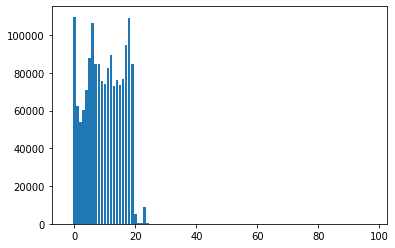

In [58]:
a = pd.read_sql("""select contract_stage, count(*) as cc from campaign_data.sd_opt_1_20200608               
group by contract_stage
""", conn)
plt.bar(a.contract_stage, a.cc)

In [38]:
pd.read_sql("""select count(*) from campaign_data.sd_opt_0_20200608                
""", conn)

_col0
0  1717990

In [32]:
df1.optout_flg.value_counts()

0    2694081
1       1937
Name: optout_flg, dtype: int64

In [35]:
print((1937/(1937+2694081)*100))

0.07184670132024341


In [12]:
# Getting optouts between 2020-07-16 and 2020-07-30
pd.read_sql("""
select optout_flg, count(*) from campaign_data.atc_sccv_raw
where brand = 'EE'
and date_of_delivery = date_parse('2020-06-16', '%Y-%m-%d')
and channel in ('S', 'M')
group by optout_flg
limit 10
""", conn)

optout_flg   _col1
0         NaN  109783
1         1.0      23

### 04. Model Build

#### Binary

In [353]:
pd.read_sql("""select * from campaign_data.sd_opt_1_20200608 limit 100""", conn)

ee_customer_id   datepoint  optout_flg  account_num  tenure_brand_months  \
0    900101545206  2020-06-08           0    116924419                   74   
1    900121952775  2020-06-08           0    113772630                   74   
2      1107719450  2020-06-08           0    139191036                   53   
3    900127505850  2020-06-08           0    125661640                   64   
4    900110681602  2020-06-08           0    128959946                   61   
5      1123162586  2020-06-08           0    153069762                   38   
6    900109284768  2020-06-08           0    134661669                   56   
7    900121888234  2020-06-08           0    133201334                   57   
8      1136011443  2020-06-08           0    165346243                   23   
9      1124345673  2020-06-08           0    154246505                   37   
10     1127823855  2020-06-08           0    114109620                   32   
11     1121745906  2020-06-08           0    151897583                   40   
12     1004807445  2020-06-08           0    118249993                   70   
13   900124960703  2020-06-08           0    114844662                   73   
14     1122822694  2020-06-08           0    152773410                   39   
15     1116169049  2020-06-08           0    147058529                   45   
16   900096839800  2020-06-08           0    121683199                   67   
17     1102771565  2020-06-08           0    134720985                   56   
18     1088702206  2020-06-08           0    120781368                   68   
19     1141602364  2020-06-08           0    170749662                   16   
20     1152682474  2020-06-08           0    181408079                    1   
21     1106103334  2020-06-08           0    137800822                   54   
22   900125841326  2020-06-08           0    117474705                   71   
23     1110271702  2020-06-08           0    146778103                   50   
24   900112763045  2020-06-08           0    108562497                   80   
25   900101957417  2020-06-08           0    122979752                   66   
26     1081305715  2020-06-08           0    113215700                   75   
27   900126217996  2020-06-08           0    102258375                   86   
28       30694309  2020-06-08           0    115396143                    2   
29     1087711668  2020-06-08           0    119844637                   69   
30   900122218921  2020-06-08           0    152447339                   80   
31   900093670749  2020-06-08           0    105485562                   83   
32     1086036694  2020-06-08           0    118122427                   70   
33     1140558793  2020-06-08           0    169768575                   17   
34   900101947917  2020-06-08           0    105060063                   83   
35     1103734944  2020-06-08           0     26796094                   56   
36     1107110282  2020-06-08           0    138550384                   53   
37       39999703  2020-06-08           0    114468477                   73   
38     1127917353  2020-06-08           0    157933104                   32   
39   900093096382  2020-06-08           0    129617884                   61   
40     1080013646  2020-06-08           0    151367108                   76   
41     1113857530  2020-06-08           0    118285928                   47   
42     1089099622  2020-06-08           0    120760238                   67   
43     1083845340  2020-06-08           0    116025603                   72   
44     1129089247  2020-06-08           0    158428117                   32   
45   900124416822  2020-06-08           0    142463044                   49   
46   900108407727  2020-06-08           0    128573705                   62   
47     1125735270  2020-06-08           0    155406632                   35   
48   900117363227  2020-06-08           0    116870236                   71   
49     1130847927  2020-06-08           0    15998770

In [354]:
df = pd.read_sql("""
select * from campaign_data.sd_opt_1_20200608 where optout_flg = 1
union all
select * 
from 
    (
    select * from campaign_data.sd_opt_1_20200608
    where optout_flg = 0
    order by random()
    limit 5000
    ) as tab1
""", conn)

In [355]:
pd.read_sql("""select optout_flg, count(*) from campaign_data.sd_opt_1_20200608 group by optout_flg""", conn)

optout_flg    _col1
0           0  1521160
1           1     1063

In [356]:
df.optout_flg.value_counts()

0    5000
1    1063
Name: optout_flg, dtype: int64

In [357]:
def count_missing(df):
    m = pd.DataFrame(df.isna().sum(), columns = ['M_COUNT'])
    m['M_COUNT_PERC'] = m['M_COUNT'] / df.shape[0]
    m['COLUMN_NAME'] = m.index
    return m


def group_precision(CHECK_FRAME):
    # Required columns are TARGET and PRED        
    # Get quantiles
    Q = pd.DataFrame([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], columns = ['Q'])
    Q['MODEL'] = CHECK_FRAME['PRED'].quantile(Q.Q).values
    
    
    # Quantile Names
    Q_NAME = []
    for i in range(len(Q)-1):
        Q_NAME = Q_NAME + [''.join(['Q', str(i+1)])]
    
    # Decile/Quantile Label
    CHECK_FRAME['MODEL_LABEL'] = ''
    for j in range(len(Q)-1):              
        CHECK_FRAME.loc[(CHECK_FRAME['PRED'] >= Q.loc[j, 'MODEL']) & (CHECK_FRAME['PRED'] <= Q.loc[j+1, 'MODEL']), 'MODEL_LABEL'] = ''.join(['Q', str(len(Q) - j - 1)])
            
    # Decile or Group Precisions
    GP = CHECK_FRAME.groupby(['MODEL_LABEL'], as_index=False).agg({'TARGET':'sum', 'PRED':'count'}).rename(columns={'PRED': 'ROW_COUNT'})
    GP['RATE'] = GP['TARGET']/GP['ROW_COUNT']
    
    return GP

In [358]:
m = count_missing(df)
print(m)

                           M_COUNT  M_COUNT_PERC                COLUMN_NAME
ee_customer_id                   2      0.000330             ee_customer_id
datepoint                        0      0.000000                  datepoint
optout_flg                       0      0.000000                 optout_flg
account_num                    173      0.028534                account_num
tenure_brand_months            173      0.028534        tenure_brand_months
contract_stage                 173      0.028534             contract_stage
mrc_incl_vat                   196      0.032327               mrc_incl_vat
contract_duration              196      0.032327          contract_duration
total_allowance_mins           196      0.032327       total_allowance_mins
total_allowance_text           196      0.032327       total_allowance_text
total_allowance_data           196      0.032327       total_allowance_data
sharer_flag                    196      0.032327                sharer_flag
product_grou

In [372]:
df2 = df.dropna().reset_index(drop=True)
df2['TARGET'] = df2['optout_flg']
df2 = df2.drop(columns = ['ee_customer_id', 'datepoint', 'optout_flg', 'account_num'])
df2.head()

tenure_brand_months  contract_stage  mrc_incl_vat  contract_duration  \
0                 79.0            14.0          63.0               24.0   
1                 69.0            19.0          58.0               24.0   
2                 79.0             7.0          49.0               24.0   
3                 58.0            10.0          59.0               24.0   
4                 12.0            12.0          44.0               24.0   

   total_allowance_mins  total_allowance_text  total_allowance_data  \
0               99999.0               99999.0               60000.0   
1               99999.0               99999.0               20000.0   
2               99999.0               99999.0               30000.0   
3               99999.0               99999.0               10000.0   
4               99999.0               99999.0                4000.0   

  sharer_flag product_group  comms_received  days_from_last_comm  \
0           N       Handset              21                   26   
1           N       Handset              35                   18   
2           N       Handset              30                   12   
3           N       Handset              40                   12   
4           N       Handset              29                   12   

   avg_weekly_comm  campaign_mix  channel_mix  justbought  credit_class_1  \
0         1.000000             1            1         0.0             0.0   
1         1.500000             2            3         0.0             0.0   
2         1.500000             3            2         0.0             0.0   
3         1.500000             3            3         0.0             0.0   
4         1.333333             2            2         0.0             0.0   

   credit_class_2  credit_class_3  credit_class_4  credit_class_5  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   credit_class_6  credit_class_7  credit_class_8  credit_class_9  \
0             0.0             0.0             2.0             0.0   
1             0.0             0.0             1.0             0.0   
2             0.0             2.0             0.0             0.0   
3             0.0             0.0             1.0             0.0   
4             0.0             0.0             1.0             0.0   

   credit_class_oth  topend_hs  activesub  a_tenure_lifetime_months  \
0               0.0        2.0        2.0                     225.0   
1               0.0        1.0        1.0                     133.0   
2               0.0        1.0        2.0                     134.0   
3               0.0        1.0        1.0                     153.0   
4               0.0        1.0        1.0                     245.0   

   a_tenure_brand_months  a_inlife  a_tenure  a_ooc  a_ooctenue  \
0                  154.0       2.0      17.0    0.0         0.0   
1                   69.0       1.0      19.0    0.0         0.0   
2                  134.0       1.0      38.0    1.0        19.0   
3                   58.0       1.0      10.0    0.0         0.0   
4                   12.0       1.0      12.0    0.0         0.0   

   a_upgradeeleg  a_upgradetenure  a_handsetcount  a_mbbcount  a_simocount  \
0            0.0              0.0             2.0         0.0          0.0   
1            0.0              0.0             1.0         0.0          0.0   
2            0.0              0.0             1.0         1.0          0.0   
3            0.0              0.0             1.0         0.0          0.0   
4            0.0              0.0             1.0         0.0          0.0   

   a_tabletcount  a_watchcount  a_basembb  a_basevoice  a_basesimo  \
0            0.0           0.0        0.0          2.0

In [373]:
df2.shape

(5867, 218)

In [374]:
# Some FE
df3 = pd.concat([df2, pd.get_dummies(df2.product_group, dummy_na=True, prefix = 'product_group')], axis = 1).drop(columns=['product_group']).reset_index(drop=True)
df3 = pd.concat([df3, pd.get_dummies(df2.sharer_flag, dummy_na=True, prefix='sharer')], axis=1).drop(columns=['sharer_flag']).reset_index(drop=True)
df3

tenure_brand_months  contract_stage  mrc_incl_vat  contract_duration  \
0                    79.0            14.0         63.00               24.0   
1                    69.0            19.0         58.00               24.0   
2                    79.0             7.0         49.00               24.0   
3                    58.0            10.0         59.00               24.0   
4                    12.0            12.0         44.00               24.0   
...                   ...             ...           ...                ...   
5862                 59.0             0.0         13.00               24.0   
5863                 71.0            71.0         11.99               12.0   
5864                 42.0            42.0         34.99               12.0   
5865                 73.0            12.0         64.00               24.0   
5866                 81.0            12.0         39.00               24.0   

      total_allowance_mins  total_allowance_text  total_allowance_data  \
0                  99999.0               99999.0               60000.0   
1                  99999.0               99999.0               20000.0   
2                  99999.0               99999.0               30000.0   
3                  99999.0               99999.0               10000.0   
4                  99999.0               99999.0                4000.0   
...                    ...                   ...                   ...   
5862               99999.0               99999.0                1000.0   
5863                1000.0               99999.0                 250.0   
5864               99999.0               99999.0               20000.0   
5865               99999.0               99999.0               30000.0   
5866               99999.0               99999.0                4000.0   

      comms_received  days_from_last_comm  avg_weekly_comm  campaign_mix  \
0                 21                   26         1.000000             1   
1                 35                   18         1.500000             2   
2                 30                   12         1.500000             3   
3                 40                   12         1.500000             3   
4                 29                   12         1.333333             2   
...              ...                  ...              ...           ...   
5862              17                    5         1.000000             2   
5863              13                   42         1.000000             1   
5864              16                   65         0.000000             0   
5865              28                   12         1.000000             3   
5866              39                   12         1.800000             4   

      channel_mix  justbought  credit_class_1  credit_class_2  credit_class_3  \
0               1         0.0             0.0             0.0             0.0   
1               3         0.0             0.0             0.0             0.0   
2               2         0.0             0.0             0.0             0.0   
3               3         0.0             0.0             0.0             0.0   
4               2         0.0             0.0             0.0             0.0   
...           ...         ...             ...             ...             ...   
5862            2         0.0             0.0             0.0             0.0   
5863            1         0.0             0.0             0.0             0.0   
5864            0         0.0             0.0             0.0             0.0   
5865            2         0.0             0.0             0.0             0.0   
5866            3         0.0             0.0             0.0             0.0   

      credit_class_4  credit_class_5  credit_class_6  credit_class_7  \
0                0.0             0.0             0.0             0.0   
1                0.0             0.0             0.0             0.0   
2                0.0             0.0             0.0             2.0   
3     

In [375]:
df3.shape
print(count_missing(df3))

                                   M_COUNT  M_COUNT_PERC  \
tenure_brand_months                      0           0.0   
contract_stage                           0           0.0   
mrc_incl_vat                             0           0.0   
contract_duration                        0           0.0   
total_allowance_mins                     0           0.0   
total_allowance_text                     0           0.0   
total_allowance_data                     0           0.0   
comms_received                           0           0.0   
days_from_last_comm                      0           0.0   
avg_weekly_comm                          0           0.0   
campaign_mix                             0           0.0   
channel_mix                              0           0.0   
justbought                               0           0.0   
credit_class_1                           0           0.0   
credit_class_2                           0           0.0   
credit_class_3                          

In [376]:
X_SEQUENCE = df3.drop(columns=['TARGET']).columns.tolist()
print(X_SEQUENCE)

['tenure_brand_months', 'contract_stage', 'mrc_incl_vat', 'contract_duration', 'total_allowance_mins', 'total_allowance_text', 'total_allowance_data', 'comms_received', 'days_from_last_comm', 'avg_weekly_comm', 'campaign_mix', 'channel_mix', 'justbought', 'credit_class_1', 'credit_class_2', 'credit_class_3', 'credit_class_4', 'credit_class_5', 'credit_class_6', 'credit_class_7', 'credit_class_8', 'credit_class_9', 'credit_class_oth', 'topend_hs', 'activesub', 'a_tenure_lifetime_months', 'a_tenure_brand_months', 'a_inlife', 'a_tenure', 'a_ooc', 'a_ooctenue', 'a_upgradeeleg', 'a_upgradetenure', 'a_handsetcount', 'a_mbbcount', 'a_simocount', 'a_tabletcount', 'a_watchcount', 'a_basembb', 'a_basevoice', 'a_basesimo', 'a_prev_base_typembb', 'a_prev_base_typevoice', 'a_prev_base_typesimo', 'a_mrc_handset', 'a_mrc_simo', 'a_mrc_simo_contract', 'a_mrc_simo_rolling', 'a_mrc_mbb_device', 'a_mrc_tablet', 'a_mrc_mbb_device_contract', 'a_mrc_mbb_simo', 'a_mrc_mbb_device_rolling', 'a_mrc_watch', 'a_m

In [378]:
OPTOUT = df3.copy()
X = OPTOUT.loc[:, X_SEQUENCE]
y = OPTOUT['TARGET'].values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1,test_size=0.2)

# Build a model
BIN_MODEL = RandomForestClassifier(random_state=0, n_estimators = 210, max_features = 100)

In [379]:
BIN_MODEL.fit(X_train, y_train)

RandomForestClassifier(max_features=100, n_estimators=210, random_state=0)

In [380]:
y_hat = BIN_MODEL.predict_proba(X_test.loc[:, X_SEQUENCE])
#y_hat = np.where(pd.DataFrame(y_hat, columns = ['pred_0', 'pred_1']).pred_1.values >= 0.7, 1, 0)

CHECK_FRAME = pd.DataFrame(y_test, columns = ['TARGET'])
CHECK_FRAME['PRED'] = pd.DataFrame(y_hat, columns = ['pred_0', 'pred_1']).pred_1

GP = group_precision(CHECK_FRAME)
GP['Q_NUM'] = GP.MODEL_LABEL.str.extract('(\d+)').astype(int)
GP = GP.sort_values(['Q_NUM'], ascending = [False])
GP['RANDOM'] = GP['TARGET'].sum()/GP['ROW_COUNT'].sum()

In [381]:
GP

MODEL_LABEL  TARGET  ROW_COUNT      RATE  Q_NUM    RANDOM
1         Q10      11        105  0.104762     10  0.166951
9          Q9      17        115  0.147826      9  0.166951
8          Q8      15        110  0.136364      8  0.166951
7          Q7      17        130  0.130769      7  0.166951
6          Q6      18        120  0.150000      6  0.166951
5          Q5      19        120  0.158333      5  0.166951
4          Q4      16        119  0.134454      4  0.166951
3          Q3      28        116  0.241379      3  0.166951
2          Q2      23        112  0.205357      2  0.166951
0          Q1      32        127  0.251969      1  0.166951

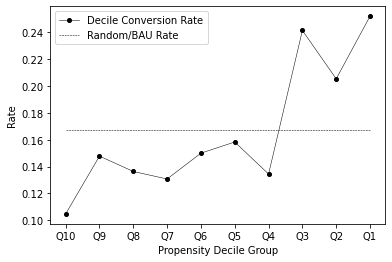

In [382]:
plt.plot('MODEL_LABEL', 'RATE', data = GP, marker = 'o', color = 'black', markersize = 4, linewidth=0.5)
plt.plot('MODEL_LABEL', 'RANDOM', data = GP, color = 'black', linestyle='dashed', markersize = 4, linewidth=0.5)
plt.ylabel('Rate')
plt.xlabel('Propensity Decile Group')
plt.legend(['Decile Conversion Rate', 'Random/BAU Rate'])

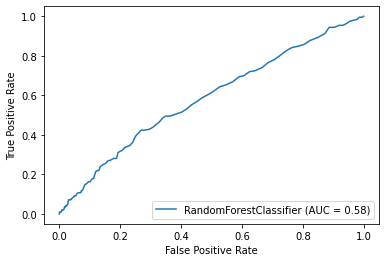

In [383]:
sklearn.metrics.plot_roc_curve(BIN_MODEL, X_test, y_test)

In [384]:
# Variable importance columns
imp = pd.DataFrame(X_SEQUENCE, columns = ['X'])
imp['imp'] = BIN_MODEL.feature_importances_
imp = imp.sort_values(['imp'], ascending=[False]).reset_index(drop = True)
print(imp)

                                     X       imp
0             a_tenure_lifetime_months  0.098668
1                       comms_received  0.076219
2                a_tenure_brand_months  0.070309
3                  tenure_brand_months  0.069315
4                       contract_stage  0.049517
5                             a_tenure  0.045458
6                                a_mrc  0.044580
7                  days_from_last_comm  0.042164
8                         mrc_incl_vat  0.041832
9                      avg_weekly_comm  0.033769
10                total_allowance_data  0.032812
11                       a_mrc_handset  0.028345
12                        campaign_mix  0.021965
13                         channel_mix  0.018653
14                 a_mrc_simo_contract  0.014569
15                          a_ooctenue  0.014477
16               a_prev_base_typevoice  0.011415
17                      credit_class_7  0.011138
18                      credit_class_8  0.010785
19                a_

In [385]:
cf = pd.read_sql("select * from campaign_data.sd_opt_1_20200807", conn)

In [386]:
df2 = cf.dropna().reset_index(drop=True)
df2['TARGET'] = df2['optout_flg']
df2 = df2.drop(columns = ['ee_customer_id', 'datepoint', 'optout_flg', 'account_num'])
df3 = pd.concat([df2, pd.get_dummies(df2.product_group, dummy_na=True, prefix = 'product_group')], axis = 1).drop(columns=['product_group']).reset_index(drop=True)
df3 = pd.concat([df3, pd.get_dummies(df2.sharer_flag, dummy_na=True, prefix='sharer')], axis=1).drop(columns=['sharer_flag']).reset_index(drop=True)
df3

tenure_brand_months  contract_stage  mrc_incl_vat  contract_duration  \
0                      21.0             0.0         33.00               24.0   
1                      61.0            13.0         69.00               24.0   
2                      86.0            32.0         77.99               24.0   
3                      78.0            11.0         59.00               24.0   
4                      11.0             0.0         49.00               24.0   
...                     ...             ...           ...                ...   
234002                 47.0            22.0         48.00               24.0   
234003                 77.0            20.0         53.00               24.0   
234004                 19.0            19.0         43.00               24.0   
234005                 53.0             2.0         54.00               24.0   
234006                 76.0            23.0         53.00               24.0   

        total_allowance_mins  total_allowance_text  total_allowance_data  \
0                    99999.0               99999.0               40000.0   
1                    99999.0               99999.0               60000.0   
2                    99999.0               99999.0              100000.0   
3                    99999.0               99999.0               10000.0   
4                    99999.0               99999.0               40000.0   
...                      ...                   ...                   ...   
234002               99999.0               99999.0               60000.0   
234003               99999.0               99999.0               30000.0   
234004               99999.0               99999.0               60000.0   
234005               99999.0               99999.0               10000.0   
234006               99999.0               99999.0               30000.0   

        comms_received  days_from_last_comm  avg_weekly_comm  campaign_mix  \
0                    6                    1         1.000000             1   
1                   40                    7         1.333333             2   
2                   19                   18         1.000000             1   
3                   33                    7         1.333333             2   
4                   22                   18         2.000000             1   
...                ...                  ...              ...           ...   
234002              28                   67         0.000000             0   
234003              18                   23         1.000000             1   
234004              18                    8         1.000000             2   
234005               8                   28         1.000000             2   
234006              37                    1         1.000000             1   

        channel_mix  justbought  credit_class_1  credit_class_2  \
0                 2         1.0             0.0             0.0   
1                 1         0.0             0.0             0.0   
2                 1         0.0             0.0             0.0   
3                 1         0.0             0.0             0.0   
4                 1         0.0             0.0             0.0   
...             ...         ...             ...             ...   
234002            0         0.0             0.0             0.0   
234003            1         0.0             0.0             0.0   
234004            1         0.0             0.0             0.0   
234005            2         0.0             0.0             0.0   
234006            1         0.0             0.0             0.0   

        credit_class_3  credit_class_4  credit_class_5  credit_class_6  \
0                  0.0             0.0             0.0             0.0   
1                  0.0             0.0             0.0             0.0   
2                  0.0             0.0             0.0             0.0   
3                  0.0             0.0             0.0             0.0   
4                  0.0

In [259]:
print(X_SEQUENCE)
df3.columns

['tenure_brand_months', 'contract_stage', 'mrc_incl_vat', 'contract_duration', 'total_allowance_mins', 'total_allowance_text', 'total_allowance_data', 'comms_received', 'days_from_last_comm', 'avg_weekly_comm', 'campaign_mix', 'channel_mix', 'product_group_Handset', 'product_group_MBB Device Contract', 'product_group_SIMO Contract', 'product_group_SIMO Rolling', 'product_group_nan', 'sharer_N', 'sharer_Y', 'sharer_nan']


Index(['tenure_brand_months', 'contract_stage', 'mrc_incl_vat',
       'contract_duration', 'total_allowance_mins', 'total_allowance_text',
       'total_allowance_data', 'comms_received', 'days_from_last_comm',
       'avg_weekly_comm', 'campaign_mix', 'channel_mix', 'TARGET',
       'product_group_Handset', 'product_group_MBB Connected',
       'product_group_MBB Device Contract', 'product_group_MBB Device Rolling',
       'product_group_MBB SIMO', 'product_group_SIMO Contract',
       'product_group_SIMO Rolling', 'product_group_Tablet',
       'product_group_Watch', 'product_group_nan', 'sharer_N', 'sharer_Y',
       'sharer_nan'],
      dtype='object')

In [387]:
y_test = df3.TARGET.values
y_hat = BIN_MODEL.predict_proba(df3.loc[:, X_SEQUENCE])

#y_hat = np.where(pd.DataFrame(y_hat, columns = ['pred_0', 'pred_1']).pred_1.values >= 0.7, 1, 0)

CHECK_FRAME = pd.DataFrame(y_test, columns = ['TARGET'])
CHECK_FRAME['PRED'] = pd.DataFrame(y_hat, columns = ['pred_0', 'pred_1']).pred_1

GP = group_precision(CHECK_FRAME)
GP['Q_NUM'] = GP.MODEL_LABEL.str.extract('(\d+)').astype(int)
GP = GP.sort_values(['Q_NUM'], ascending = [False])
GP['RANDOM'] = GP['TARGET'].sum()/GP['ROW_COUNT'].sum()

In [388]:
GP

MODEL_LABEL  TARGET  ROW_COUNT      RATE  Q_NUM    RANDOM
1         Q10       6      22068  0.000272     10  0.000402
9          Q9      10      23873  0.000419      9  0.000402
8          Q8       8      22269  0.000359      8  0.000402
7          Q7       8      23960  0.000334      7  0.000402
6          Q6      10      23776  0.000421      6  0.000402
5          Q5       8      22474  0.000356      5  0.000402
4          Q4       7      22753  0.000308      4  0.000402
3          Q3      13      25727  0.000505      3  0.000402
2          Q2       7      23088  0.000303      2  0.000402
0          Q1      17      24019  0.000708      1  0.000402

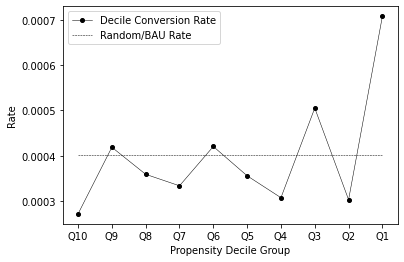

In [389]:
plt.plot('MODEL_LABEL', 'RATE', data = GP, marker = 'o', color = 'black', markersize = 4, linewidth=0.5)
plt.plot('MODEL_LABEL', 'RANDOM', data = GP, color = 'black', linestyle='dashed', markersize = 4, linewidth=0.5)
plt.ylabel('Rate')
plt.xlabel('Propensity Decile Group')
plt.legend(['Decile Conversion Rate', 'Random/BAU Rate'])

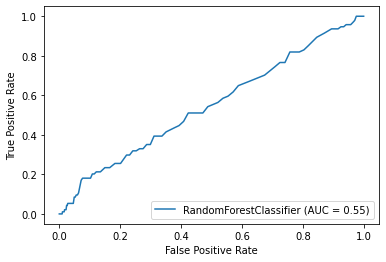

In [390]:
sklearn.metrics.plot_roc_curve(BIN_MODEL, df3.loc[:, X_SEQUENCE], y_test)

### 05. Model Save

In [269]:
# dump joblib file
joblib.dump(BIN_MODEL, 'optout_model.joblib')

['optout_model.joblib']